# Reducing Network Polarization

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import style
import networkx as nx
import random
from itertools import product, permutations
import time
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

style.use('ggplot')
np.random.seed(8) 


In [2]:
''' 
MDP environment definition:

state = tuple(all opinions) - Partial observability
actions = [(j, i)] "node j influences node i (and j remains the same)"
reward = polarization change from previous state boosted if reduced s_tot
guidance reward = negative small reward at every step to promote speed
terminal reward = +1000 if all nodes in new state have opinion 0,
                  -100 if all nodes have same-ish opinion but not 0
'''

' \nMDP environment definition:\n\nstate = tuple(all opinions) - Partial observability\nactions = [(j, i)] "node j influences node i (and j remains the same)"\nreward = polarization change from previous state boosted if reduced s_tot\nguidance reward = negative small reward at every step to promote speed\nterminal reward = +1000 if all nodes in new state have opinion 0,\n                  -100 if all nodes have same-ish opinion but not 0\n'

In [3]:
p = 0.5 # prob_of_intraconnection
q = 0.2 # prob_of_interconnection 
opinions_bag = [-1.0, -0.5, 0.0, 0.5, 1.0]

# ~ all definitions from phase I ~

In [4]:
def apply_recommendation(s_i, s_j):
    ''' 
    Returns a 'next states' list of tuples as: [(probability, new_opinion value)]
    following the given influence rules. Assumes a step = 0.5.
    The equivalent of the opinion_update() we defined above, but for the MDP setting 
    (i.e. needed to create transition probabilites matrix)
    '''
    step = 0.5
    diff = abs(s_i - s_j)
    
    if diff ==0.5:
        return [(0.6, s_j), (0.4, s_i)] # with probability 0.6, s_i_new = s_j, with p=0.4, s_i_new = s_i_old
        
    elif diff >= 1:
        next_states = []
        move = step*2

        sign = 1 if s_j> s_i else -1
        towards = s_i + sign * move
        away = s_i - sign * step

        towards = max(-1, min(1, towards))
        away = max(-1, min(1, away))
        new_states = [(0.4, towards), (0.3, s_i), (0.3, away)]
        return new_states
    else:
        return[(1.0, s_i)]

In [5]:
def is_terminal(state):
    ''' 
    Takes in a state (all nodes' opinions) and
    returns `done` , `reward` values.
    I define my terminal states those where all
    opinions are equal. If they are zero, i get
    a positive reward, otherwise I get negative 
    terminal reward.
    '''
    unique = set(state)
    if len(unique) == 1:  # if all nodes' opinions end up being the same:
        if abs(state[0]) == 0:
            return True, +20
        else:
            return True, -20
    return False, 0

In [6]:
def force_no_isolates(graph):
    '''
    Connects isolated nodes randomly to other nodes.
    '''
    print('Connecting isolated nodes randomly...')
    isolates = list(nx.isolates(graph))
    print(f'  List of isolated nodes:  {isolates}')
    for n in isolates:
        not_isolates = list(set(graph.nodes()) - {n})
        some_connected_guy = int(np.random.choice(not_isolates))
        graph.add_edge(n, some_connected_guy)

In [7]:
def get_valid_actions_list(graph):
    '''
    Returns a list of all edges of a graph in bidirectional manner.
    The list corresponds to the permitted actions for my RL agent.
    '''
    edges = list(graph.edges)
    actions = [ (g, h) for g, h in edges] + [(h, g) for g, h in edges]
    return actions

In [8]:
def get_total_polarization(graph):
    ''' 
    Returns the sum of absolute values of opinion attributes of all nodes
    We define this quantity as the total polarization.
    '''
    values = nx.get_node_attributes(graph, 'opinion').values()
    opinion_list = np.array(list(values))
    total_polarization = np.sum(np.abs(opinion_list))
    return total_polarization

In [9]:
def create_random_net(N, p=p):  
    '''
    Creates a random graph network with N nodes,
    with probability of intraconnection p.
    Returns graph G, states s, actions a.
    --------------------------------------
    TODO: make sure there is connecting path from
    every node to every node. Now there are cases 
    where it returns isolated groups. And force_no_
    isolates is not enough backup.
    '''    
    print('Creating graph...')
    G = nx.Graph()
    G.add_nodes_from(range(N))

    opinions = np.random.choice(opinions_bag, size = N).tolist()
    
    nx.set_node_attributes(G, values = {i: opinions[i] for i in range(N)}, name = 'opinion')

    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() > p:
                G.add_edge(i,j)
    if len(list(nx.isolates(G))) > 0:
        force_no_isolates(G)
        
            
    actions = get_valid_actions_list(G)    
    states = list(product(opinions_bag, repeat=N))

    G.graph['n_s'] = len(states)
    G.graph['n_a'] = len(actions)
    G.graph['initial_opinions'] = opinions
    G.graph['current_state'] = opinions

    
    print('Number of states for this graph:' ,len(states), '\n  Number of possible actions:', len(actions))    
    print('  Nodes\' initial opinions', opinions)
    print('  Total polarization:', get_total_polarization(G))
    
    
    return G, states, actions

In [10]:
def force_no_isolates_in_chambers(graph, group):
    '''
    Connects isolated nodes randomly within their group.
    '''
    print('Connecting isolated nodes randomly...')
    for n in group:
        friends = set(graph[n])  # I get the adjacent nodes
        if len(friends.intersection(group)) == 0:
            some_connected_friend = int(np.random.choice([node for node in group if node != n]))
            graph.add_edge(n, some_connected_friend)
        

    

In [11]:
def create_echo_chambers(N, p=p, q=q):
    '''
    Creates a random graph network with N nodes, assigns
    opinions and separates in two equal 'echo-chambers' 
    with probability of intraconnection p 
    and probability of interconnection q. 
    If number of nodes is not even , it adds 1 node.
    '''
    
    print('Creating graph...')

    if N % 2 == 1:
        N += 1
        print('Added one extra node to get equal numbered chambers. Total nodes now: ', N)
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    group1 = list(range(N//2))
    group2 = list(range(N//2, N)) # N must be even
    
    opinions_group1 = np.random.choice([-1.0, -0.5], size= N//2)  # initial opinions
    opinions_group2 = np.random.choice([0.5, 1.0], size= N//2)    # do not contain neutral opinions
    
    opinions = np.concatenate([opinions_group1, opinions_group2])
    nx.set_node_attributes(G, values= {i: opinions[i] for i in range(N)}, name='opinion')
    
    # intraconnect:
    for group in [group1, group2]:       # in each group
        for i in range(len(group)):      # for each node 
            for j in range(i+1, len(group)): # see the other (remaining ) nodes
                if np.random.rand() < p:     # and with probability p
                    G.add_edge(group[i], group[j]) # connect them together.
        if len(list(nx.isolates(G))) > 0:          # if some isolates happened,
            force_no_isolates_in_chambers(G, group) # connect them randomly for now.
    
    
    # interconnect:
    for i in group1:
        for j in group2:
            if np.random.rand() < q:
                G.add_edge(i,j)
    
    # making sure I don't get isolated chambers:
    if not any(G.has_edge(i,j) for i in group1 for j in group2): 
        i = int(np.random.choice(group1))
        j = int(np.random.choice(group2))
        G.add_edge(i,j)

    actions = get_valid_actions_list(G)    
    states = list(product(opinions_bag, repeat=N))    
    G.graph['n_s'] = len(states)
    G.graph['n_a'] = len(actions)
    G.graph['initial_opinions'] = opinions
    G.graph['current_state'] = opinions
    
    print('Number of states for this graph:' ,len(states), '\n  Number of possible actions:', len(actions))    
    print('  Nodes\' initial opinions', opinions)
    print('  Total polarization:', get_total_polarization(G))

    
    return G, states, actions

In [12]:
def draw_opinion_graph(graph, random = False, filename = None):
    '''
    Simple function to quickly draw the networkx opinion graph with the correct formatting.
    '''

    if not random:
        for i, j in graph.edges():
            s_i = graph.nodes[i]['opinion']
            s_j = graph.nodes[j]['opinion']
    
            if s_i == s_j:
                weight = 10
            elif s_i * s_j < 0:
                weight =0.5
            else:
                weight = 4
            graph[i][j]['weight'] = weight
        pos = nx.spring_layout(graph, weight='weight')
    else:
        pos = nx.spring_layout(graph)

        
    nx.draw(graph, pos, with_labels=True, 
                   node_color=[graph.nodes[i]['opinion'] for i in graph.nodes()],
                   cmap=plt.cm.coolwarm,         
                   width=0.3,                 
                  vmin = -1.0,
                  vmax = 1.0)
    plt.text(0.01, 0.09, f"Number of states: {graph.graph['n_s']}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom')
    plt.text(0.01, 0.05, f"Number of actions: {graph.graph['n_a']}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom')

    if filename:
        plt.savefig(filename)
    plt.show()

    return
 

In [13]:
def create_transition_prob(graph, states, actions):
    '''
    Takes a graph, its states and valid actions, 
    and creates the transition probability matrix.
    Returns the P, and the dictionaries of the state indexes.
    '''
    # opinions = [-1.0, -0.5, 0.5, 1.0] if not echo else [-1.0, -0.5, 0, 0.5, 1.0]
        
    
    N = graph.number_of_nodes()
    states = states

    # Essential dictionaries which willl guide the transitions:
    state_to_index = {s: i for i, s in enumerate(states)}
    index_to_state = {i: s for i, s in enumerate(states)}
    print(f'For the graph {graph} \n \ with Number of states {len(states)} \n \ and number of possible actions {len(actions)}')
    print(' Creating matrix P ...')
    
    
    ###############################################
    ### CREATING THE !!! TRANSITION TABLE !!!!! ###
    ###############################################
    P = [[[] for _ in actions] for _ in states]  # it is a list: [ state1, state2,...] where state1 = [action1, action2...]
                                                    #and where action1 = [transition_prob_info]
                                                    # and where transition_prob_info = [prob, nextstate, reward, done]
    for i, state in enumerate(states):
        
        for a_index, (i_node, j_node) in enumerate(actions):
            s_i, s_j = state[i_node], state[j_node]
            transitions = apply_recommendation(s_i, s_j) # here I actually get the next state of each s,a with the 
                                                            # coressponding transition probability ( P, s_i_new)
            # now for each transition probability of the influenced node:
            for prob, s_i_new in transitions:
                new_state = list(state)                  # I convert the tuple state to list
                new_state[i_node] = s_i_new              # I change the state of the (changed) node
                new_state = tuple(new_state)             # I convert the list to tuple
                next_state_index = state_to_index[new_state]        # to find where in the transition table is my new state
                
                done, terminal_reward = is_terminal(new_state)   # I check if my new state is terminal
                
                # reward = s_i_new + terminal_reward - 1

                reward = -sum(abs(x) for x in new_state) + terminal_reward       
                if terminal_reward == 0: # giving some intermediate "guidance" to discourage/avoid stalling
                    if all(x > 0 for x in new_state) or all(x < 0 for x in new_state):
                        reward -= 5
                    
                
                P[i][a_index].append((prob, next_state_index, reward, done))
    ###############################################
    #############           !           ###########
    ###############################################
    
    print(' P matrix created.\n Format: P[state-index][action-index] = \n        [(probability of transition, next state index number, reward, done)].')

    return P, state_to_index, index_to_state
    

In [14]:
def random_policy(P):
    '''
    Takes a transition probability 'matrix' and returns
    a random policy pi, in which chooses a random index from the
    list of available indices of a state P[s].
    '''
    random_pi = lambda s: np.random.choice([a for a in range(len(P[s]))])
    return random_pi

In [15]:
def biased_policy(P,actions, index_to_state):
    '''
    Takes a transition probability 'matrix', list of valid
    actions and the indices which corresponf each state. 
    Returns a biased policy which chooses always the
    the j node with the smallest difference in opinions.
    ---------------------------------------------------
    NOTE: AI declaration: ChatGPT was uded to create this lambda
    function in this manner. I take minimal credit for this.
    ---------------------------------------------------
    '''
    pi = lambda s: min(
        range(len(actions)),
        key=lambda a_idx: abs(index_to_state[s][actions[a_idx][0]] - index_to_state[s][actions[a_idx][1]])
    )
    return pi


In [16]:
def value_iteration(P, actions, index_to_state, gamma=1.0, epsilon=1e-10, verbose=False):
    ''' 
    My value iteration function. Followed the FrozenLake example format
    as well as a few examples from https://github.com/JerryJohnThomas .
    '''
    print('Starting Value Iteration...')
    vprint = print if verbose else lambda *a, **k: None
    
    V = np.zeros(len(P))
    t = 0

    while True:
        t +=1
        Q = np.zeros((len(P), len(P[0])))
        
        for s in range(len(P)):                # s is the state index and a is the action index in the P list (of lists of lists)
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * ( reward + gamma*V[next_state]*(not done) )   

        V_new = np.max(Q, axis=1)
        if np.max(np.abs(V - V_new)) < epsilon:
            break        
        V = V_new

    pi = lambda s: np.argmax(Q[s])           # choosing only the row of the state ...
    for i in range(len(P)):
        best_action_index = pi(i)            # ...and check for the index ... 
        best_action = actions[best_action_index]  # ...which corresponds to the max val of the action.
        vprint(f'State {index_to_state[i]} --> Best action {best_action}')

    print('Converged after %d iterations' %t)  # number of iterations to converge
    # print(f'optimal pi: {pi}')
    return V, pi

In [17]:
def simulate_policy_and_plot(P, pi, state_to_index, index_to_state, actions, initial_state, rounds=10, filename=None):
    '''
    Takes the transition probabilities P,
    the optimal policy pi from the Value Iteration,
    is guided with indexes in P,
    takes the list of possible actions,
    an initial state (given tuple) and assumes steps = 10.
    '''
    print('Starting simulation...')

    current_state = initial_state
    polarization_history = []

    print(f'Initial state: {current_state}')

    for r in range(rounds):
        polarization = sum(abs(x) for x in current_state)
        polarization_history.append(polarization)

        s = state_to_index[current_state]
        a = pi(s)
        action = actions[a]

        transitions = P[s][a]                  # transition procedure starts
        probs = [t[0] for t in transitions]
        outcomes = [t[1:] for t in transitions]
        chosen = random.choices(outcomes, weights=probs, k=1)[0]
        next_state_index, reward, done = chosen
        next_state = index_to_state[next_state_index]   
        print(f'Round {r + 1}: Action {action}, Next State {next_state}, Polarization {polarization:.2f}')
        current_state = next_state        # transition procedure ends

        if done:
            print('--- Episode Terminated ---')
            break

    polarization = sum(abs(x) for x in current_state) # getting the final polarization 
    polarization_history.append(polarization)         # and logging it for plotting

    # plotting 
    plt.figure()
    plt.plot(polarization_history, marker='o')
    plt.title('Total Polarization Over Time')
    plt.xlabel('Time step')
    plt.ylabel('Total Polarization')
    plt.xticks(range(len(polarization_history))) 
    plt.yticks(np.arange(0, max(polarization_history) + 1, 0.5))
    # plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()
    return


In [18]:
def create_validation_net(N, p=p, opinions=[_]):  
    '''
    Creates a graph network with N nodes,
    and with set opinion attributes.
    Returns graph G, states s, actions a.
    '''    
    print('Creating graph...')
    G = nx.Graph()
    G.add_nodes_from(range(N))

    opinions = opinions
    
    nx.set_node_attributes(G, values = {i: opinions[i] for i in range(N)}, name = 'opinion')

    for i in range(N-1):
        # for j in range(i+1, N):
        G.add_edge(i,i+1)        
            
    actions = get_valid_actions_list(G)    
    states = list(product(opinions_bag, repeat=N))

    G.graph['n_s'] = len(states)
    G.graph['n_a'] = len(actions)
    G.graph['initial_opinions'] = opinions
    G.graph['current_state'] = opinions
    values = nx.get_node_attributes(G, 'opinion').values()
    opinion_list = np.array(list(values))
    total_polarization = np.sum(np.abs(opinion_list))
    
    print('Number of states for this graph:' ,len(states), '\n  Number of possible actions:', len(actions))    
    print('  Nodes\' initial opinions', opinions)
    print('  Total polarization:', total_polarization)
    
    
    return G, states, actions

# Examples of phase I with updated reward structure

reward structure as: (polarization_before - polarization_after )

Creating graph...
Number of states for this graph: 15625 
  Number of possible actions: 16
  Nodes' initial opinions [0.5, 1.0, -0.5, -0.5, 0.0, -1.0]
  Total polarization: 3.5


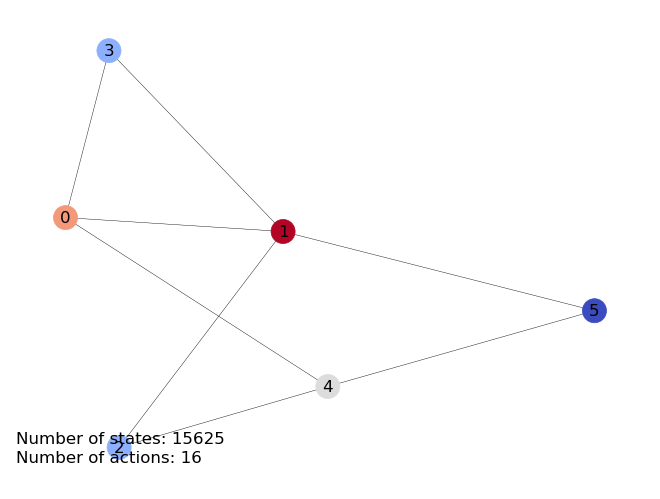

In [19]:
G1, states1, actions1 = create_random_net(6)
draw_opinion_graph(G1, random = True, filename='./figures/phase-II//G1-6.png')

For the graph Graph with 6 nodes and 8 edges 
 \ with Number of states 15625 
 \ and number of possible actions 16
 Creating matrix P ...
 P matrix created.
 Format: P[state-index][action-index] = 
        [(probability of transition, next state index number, reward, done)].
Starting Value Iteration...
Converged after 65 iterations
  VI took 20.1548 seconds

Starting simulation...
Initial state: (0.5, 1.0, -0.5, -0.5, 0.0, -1.0)
Round 1: Action (1, 2), Next State (0.5, 0.0, -0.5, -0.5, 0.0, -1.0), Polarization 3.50
Round 2: Action (5, 1), Next State (0.5, 0.0, -0.5, -0.5, 0.0, -1.0), Polarization 2.50
Round 3: Action (5, 1), Next State (0.5, 0.0, -0.5, -0.5, 0.0, 0.0), Polarization 2.50
Round 4: Action (0, 1), Next State (0.5, 0.0, -0.5, -0.5, 0.0, 0.0), Polarization 1.50
Round 5: Action (0, 1), Next State (0.0, 0.0, -0.5, -0.5, 0.0, 0.0), Polarization 1.50
Round 6: Action (2, 4), Next State (0.0, 0.0, 0.0, -0.5, 0.0, 0.0), Polarization 1.00
Round 7: Action (3, 0), Next State (0.0, 0.0

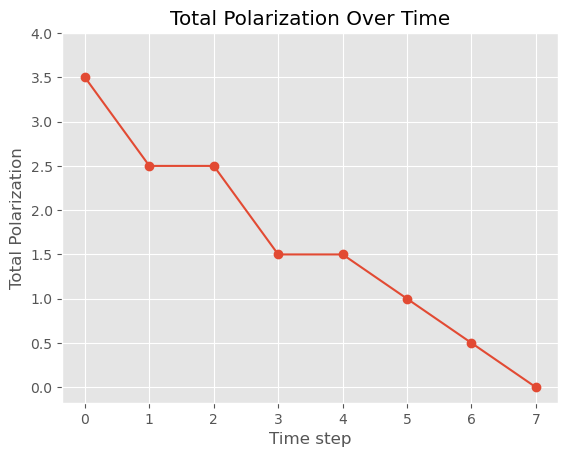

Process took 20.3197 seconds


In [20]:
# # The VI process below for 6 nodes and random graph (pictured above) is successful, takes approximately 20 seconds.
# P1, sti1, its1 = create_transition_prob(G1, states1, actions1)
# start = time.time()

# V1, pstar1 = value_iteration(P1, actions1, its1, gamma=0.9)
# end_VI = time.time()
# print(f'  VI took {end_VI - start:.4f} seconds\n')

# initial_state1 = tuple(G1.graph['initial_opinions'])
# # initial_state1 = (-0.5, -1, 0.5, 1.)
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# simulate_policy_and_plot(P1, pstar1, sti1, its1, actions1, initial_state1, 
#                          rounds=500, filename=f'./figures/phase-II/G1-Qlearn_{timestamp}.png')

# end = time.time()
# print(f'Process took {end - start:.4f} seconds')

Creating graph...
Connecting isolated nodes randomly...
Number of states for this graph: 15625 
  Number of possible actions: 12
  Nodes' initial opinions [-1.  -0.5 -0.5  0.5  0.5  1. ]
  Total polarization: 4.0


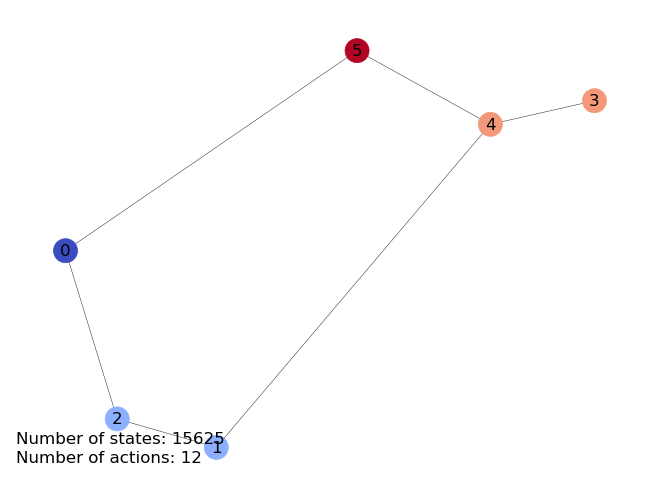

In [21]:
G2, states2, actions2 = create_echo_chambers(6)
draw_opinion_graph(G2, random = False, filename='./figures/phase-II/G2-6.png')

For the graph Graph with 6 nodes and 6 edges 
 \ with Number of states 15625 
 \ and number of possible actions 12
 Creating matrix P ...
 P matrix created.
 Format: P[state-index][action-index] = 
        [(probability of transition, next state index number, reward, done)].
Starting Value Iteration...
Converged after 65 iterations
  VI took 15.1787 seconds

Starting simulation...
Initial state: (np.float64(-1.0), np.float64(-0.5), np.float64(-0.5), np.float64(0.5), np.float64(0.5), np.float64(1.0))
Round 1: Action (0, 5), Next State (-1.0, -0.5, -0.5, 0.5, 0.5, 1.0), Polarization 4.00
Round 2: Action (0, 5), Next State (-1.0, -0.5, -0.5, 0.5, 0.5, 1.0), Polarization 4.00
Round 3: Action (0, 5), Next State (-1.0, -0.5, -0.5, 0.5, 0.5, 1.0), Polarization 4.00
Round 4: Action (0, 5), Next State (0.0, -0.5, -0.5, 0.5, 0.5, 1.0), Polarization 4.00
Round 5: Action (5, 0), Next State (0.0, -0.5, -0.5, 0.5, 0.5, 1.0), Polarization 3.00
Round 6: Action (5, 0), Next State (0.0, -0.5, -0.5, 0.5,

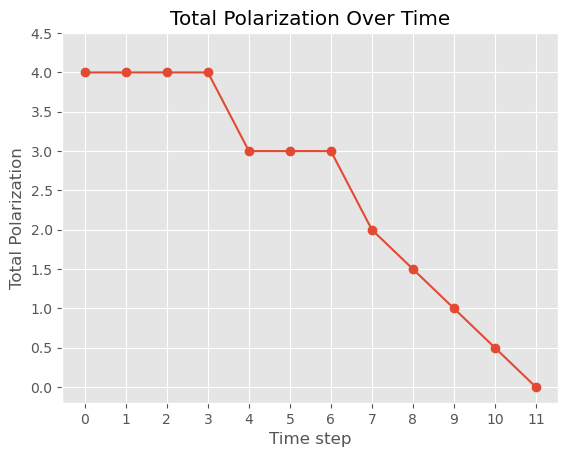

Process took 15.4111 seconds


In [23]:
# # The VI process below for 6 nodes and echo chaber graph (pictured above) is successful, takes approximately 15 seconds.
# P2, sti2, its2 = create_transition_prob(G2, states2, actions2)
# start = time.time()

# V2, pstar2 = value_iteration(P2, actions2, its2, gamma=0.9)
# end_VI = time.time()
# print(f'  VI took {end_VI - start:.4f} seconds\n')

# initial_state2 = tuple(G2.graph['initial_opinions'])
# # initial_state2 = (-0.5, -1, 0.5, 1.)
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# simulate_policy_and_plot(P2, pstar2, sti2, its2, actions2, initial_state2, 
#                          rounds=500, filename=f'./figures/phase-II/G2-Qlearn_{timestamp}.png')

# end = time.time()
# print(f'Process took {end - start:.4f} seconds')

Creating graph...
Connecting isolated nodes randomly...
Connecting isolated nodes randomly...
Number of states for this graph: 390625 
  Number of possible actions: 16
  Nodes' initial opinions [-1.  -0.5 -1.  -0.5  0.5  1.   1.   1. ]
  Total polarization: 6.5


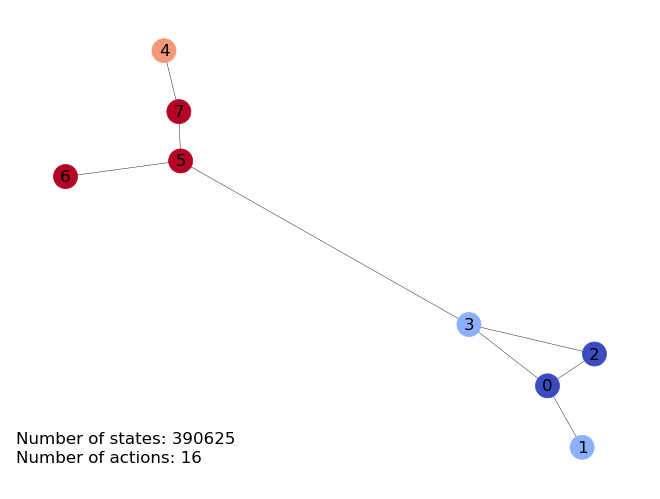

In [33]:
GB, sB, aB = create_echo_chambers(8)
draw_opinion_graph(GB, random = False)

In [24]:
# # The VI process below for 8 nodes and echo chaber graph (pictured above) is successful, but takes approximately 45 minutes.
# PB, stiB, itsB = create_transition_prob(GB, sB, aB)
# start = time.time()

# VB, pstarB = value_iteration(PB, aB, itsB, gamma=0.9)
# end_VI = time.time()
# print(f'  VI took {end_VI - start:.4f} seconds\n')

# initial_stateB = tuple(GB.graph['initial_opinions'])
# # initial_stateB = (-0.5, -1, 0.5, 1.)
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# simulate_policy_and_plot(PB, pstarB, stiB, itsB, aB, initial_stateB, 
#                          rounds=500, filename=f'./figures/phase-II/GB-Qlearn_{timestamp}.png')

# end = time.time()
# print(f'Process took {end - start:.4f} seconds')

# ~ additional definitions phase II ~

In [36]:
def train_dqn_agent(env, agent, episodes=1000, max_steps=500, batch_size=40, regenerate_graph=False, 
                    env_name=None, agent_name=None):
    episode_rewards = []
    episode_polarizations = []

    start_time = time.time()
    print(f"\nStarting training for {episodes} episodes...")
    
    for e in range(episodes):
        state = env.reset(regenerate_graph=regenerate_graph).astype(np.float32)
        initial_total_polarization = env.get_total_polarization()
        current_action_size = len(env.actions)
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < max_steps:
        # state = (state - np.mean(state)) / (np.std(state) + 1e-8) # this was to try to normalize the input for the NN, it showed little difference
            action = agent.act(state, current_action_size, training=True)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.astype(np.float32)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1

            if done or (steps >= max_steps):
                current_polarization = env.get_total_polarization()
                episode_rewards.append(total_reward)
                episode_polarizations.append(current_polarization)

                if (e + 1) % 100 == 0:  # logging a few episodes only
                    print(f"Episode: {e + 1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}, Initial Polarization: {initial_total_polarization:.2f}, Steps: {steps}, Final Polarization: {current_polarization:.2f}")
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        if (e + 1) % 10 == 0:   # Here I might be updating too frequently but it worked better while developing - this must be investigated further
            agent.update_target_model()

    duration = time.time() - start_time
    print(f"\nDQN training for {getattr(env, 'id', env.__class__.__name__)} took {duration:.2f} seconds")

    train_results = {
        'env_id': getattr(env, 'id', str(env.__class__.__name__)),
        'agent_id': getattr(agent, 'id', str(agent.__class__.__name__)),
        'env_name': env_name,
        'agent_name': agent_name,
        'episode_rewards': episode_rewards,
        'episode_polarizations': episode_polarizations}

        
    return train_results


In [25]:
def plot_training_progress(train_results, window_size=30, filename=None):
    """
    Plot with MA, & window size parameter
    """
    print('\n--- Traning progress plots ---\n')
    episode_rewards = train_results['episode_rewards']
    episode_polarizations = train_results['episode_polarizations']
    # rewards over time smoothed with Moving Average for better interpretation
    rewards_smoothed = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(12, 5)) 
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, '.', alpha=0.2, label='per episode')
    plt.plot(range(window_size-1, window_size-1+len(rewards_smoothed)), 
             rewards_smoothed, '-', linewidth=1.8, alpha=0.8, label=f"MA ({window_size} eps)")
    if (train_results['env_name'] is not None) and (train_results['agent_name'] is not None):
        plt.title(f"Training Rewards\n{train_results['env_name']} - {train_results['agent_name']}")
    else:
        plt.title(f"Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    
    # progress
    polarizations_smoothed = np.convolve(episode_polarizations, np.ones(window_size)/window_size, mode='valid')
    
    plt.subplot(1, 2, 2)
    plt.plot(episode_polarizations, '.', alpha=0.2, label='per episode')
    plt.plot(range(window_size-1, window_size-1+len(polarizations_smoothed)), 
             polarizations_smoothed, '-', linewidth=1.6, alpha=0.8, label=f"MA ({window_size} eps)")
    
    if (train_results['env_name'] is not None) and (train_results['agent_name'] is not None):
        plt.title(f"Final Polarization\n{train_results['env_name']} - {train_results['agent_name']}")
    else:
        plt.title("Final Polarization")
        
    plt.xlabel("Episode")
    plt.ylabel("Polarization")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    if filename:
        if not filename.endswith(".png"):
            filename += ".png"
        id_suffix = f"_t_".replace(":", "_").replace("/", "_")
        plt.savefig(filename.replace(".png", f"{id_suffix}.png"))
        
    plt.show()

In [26]:
def evaluate_agent(env, agent, num_episodes=200, max_steps=500, verbose=False, regenerate_graph=True):
    """
    Evaluates the trained agent and returns a few performance metrics.
    """
    env.reset()
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0  # not exploring now, evaluating my trained DQN

    init_pol = env.get_total_polarization()
    episode_rewards = []
    episode_polarizations = []
    stepwise_polarizations = []
    episode_lengths = []
    thresholds = [0.9, 0.5, 0.1] # for logging the 10%, 50% and 90% pol. reduction
    threshold_labels = {
        0.9: 'steps_to_reach_10_percent_reduction',
        0.5: 'steps_to_reach_50_percent_reduction',
        0.1: 'steps_to_reach_90_percent_reduction'}
    threshold_records = {label: [] for label in threshold_labels.values()}    

    
    for ep in range(num_episodes):
        env.reset()
        state = env.reset(regenerate_graph=regenerate_graph).astype(np.float32)
        current_action_size = len(env.actions)
        total_reward = 0
        terminated = False
        step_pols = []
        
        for step in range(max_steps):          
            action = agent.act(state, current_action_size, training=False)
            next_state, reward, done, _ = env.step(action)
            
            state = next_state.astype(np.float32)
            total_reward += reward
            current_pol = env.get_total_polarization()
            step_pols.append(current_pol)
                        
            if done:
                terminated = True
                break
        
        episode_rewards.append(total_reward)
        episode_polarizations.append(current_pol)
        stepwise_polarizations.append(step_pols)
        episode_lengths.append(len(step_pols))

        if step_pols:   # stopping the polarization reduction logging
            initial_pol = step_pols[0]
            for threshold in thresholds:
                target = initial_pol * threshold
                for idx, pol in enumerate(step_pols):
                    if pol <= target:
                        threshold_records[threshold_labels[threshold]].append(idx + 1)
                        break
                else:
                    threshold_records[threshold_labels[threshold]].append(None)        
        # print(len(step_pols), init_pol)
        if verbose and (ep % 10 == 0):
            print(f"Eval Episode {ep+1}/{num_episodes}: Reward={total_reward:.1f}, Final Polarization={current_pol:.2f}, Steps={step+1}") #, done={terminated}, opinions={state}")   #the latter for debugging was

    
    agent.epsilon = original_epsilon  # setting back the agent's epsilon

    eval_results = {
        'env_id': getattr(env, 'id', str(env.__class__.__name__)),
        'agent_id': getattr(agent, 'id', str(agent.__class__.__name__)),
        'mean_reward': np.mean(episode_rewards),
        'mean_polarization': np.mean(episode_polarizations),
        'stepwise_polarizations': stepwise_polarizations,
        'all_rewards': episode_rewards,
        'all_polarizations': episode_polarizations,
        'steps_to_reach_10_percent_reduction': np.mean([v for v in threshold_records['steps_to_reach_10_percent_reduction'] if v is not None]),
        'steps_to_reach_50_percent_reduction': np.mean([v for v in threshold_records['steps_to_reach_50_percent_reduction'] if v is not None]),
        'steps_to_reach_90_percent_reduction': np.mean([v for v in threshold_records['steps_to_reach_90_percent_reduction'] if v is not None]),
        'episode_length': np.mean(episode_lengths)}
    
    return eval_results

In [27]:
def plot_evaluation_results(eval_results, filename=None):
    """
    Visualize evaluation metrics
    """
    print("\n--- Evaluation summary ---")
    print(f"Mean Reward: {eval_results['mean_reward']:.2f}")
    print(f"Mean Final Polarization: {eval_results['mean_polarization']:.2f}")
    print(f"Mean Episode Length: {eval_results['episode_length']:.1f} steps")
    print(f"Steps to 10% Polarization Reduction: {eval_results['steps_to_reach_10_percent_reduction']:.1f} steps")
    print(f"Steps to 50% Polarization Reduction: {eval_results['steps_to_reach_50_percent_reduction']:.1f} steps")
    print(f"Steps to 90% Polarization Reduction: {eval_results['steps_to_reach_90_percent_reduction']:.1f} steps")
    
    print("\n--- Evaluation plots ---")
    plt.figure(figsize=(12, 4))
    
    # distribution of the total rewards after each episode
    plt.subplot(1, 3, 1)
    plt.hist(eval_results['all_rewards'], bins=20, alpha=0.5, edgecolor='black')
    plt.title(f"Reward Distribution\n(mean = {eval_results['mean_reward']:.1f})")
    plt.xlabel("Total Reward")
    plt.ylabel("Frequency")
    
    # distribution of the final polarizations
    plt.subplot(1, 3, 2)
    plt.hist(eval_results['all_polarizations'], bins=20, alpha=0.5, edgecolor='black')
    plt.title(f"Final Polarization\n(mean = {eval_results['mean_polarization']:.2f})")
    plt.xlabel("Polarization")
    plt.ylabel("Frequency")
    
    # polarization after each step (round)
    plt.subplot(1, 3, 3)
    for ep_pol in eval_results['stepwise_polarizations'][:-20]:  # Plot last 20 episodes
        plt.plot(ep_pol, alpha=0.4)
    plt.xlim(left=-2, right=45)
    plt.title("Polarization During Episodes")
    plt.xlabel("Step")
    plt.ylabel("Polarization")
    plt.grid(True)
    
    plt.tight_layout()
    if filename:
        if not filename.endswith(".png"):
            filename += ".png"
        id_suffix = f"_{eval_results['env_id']}_{eval_results['agent_id']}".replace(":", "_").replace("/", "_")
        plt.savefig(filename.replace(".png", f"{id_suffix}.png"))

    plt.show()
    

# Developing

## Environment Class

In [28]:
class NetworkEnvironment:
    def __init__(self, N, graph_type='random', p=p, q=q, opinions_bag=[-1.0, -0.5, 0.0, 0.5, 1.0], 
                 continuous_opinions = False, specific_initial_opinions=None, specific_initial_graph =None):
        '''
        Expects:
        graph types can be : 'random' , 'echo_chamber' , 'specific'
        list of N elemetnts for specific_initial_opinions
        nx graph of N nodes for specific_initial_graph
        '''
        self.id = f"{graph_type}_N{N}_{'C' if continuous_opinions else 'D'}"   # Trial logging for the plots , useful for later
        self.N = N
        self.graph_type = graph_type
        self.p = p #prob of intraconnect
        self.q = q #prob of interconnect
        self.opinions_bag = opinions_bag
        self.continuous_opinions = continuous_opinions
        self.specific_initial_opinions = specific_initial_opinions
        self.specific_initial_graph = specific_initial_graph
        self.graph = specific_initial_graph if specific_initial_graph is not None else self._create_graph()
        self.state = self._get_current_opinions()
        self.initial_opinions = self._get_initial_opinions()
        self.actions = self._get_valid_actions_list()

        
    def _create_graph(self):            
        if self.graph_type =='random':
            return self._create_random_net(self.N, self.p)
            
        elif self.graph_type =='echo_chamber':
            return self._create_echo_chambers(self.N, self.p, self.q)

        elif self.graph_type == 'specific':  # hopefully this is not reachable
            return self.specific_initial_graph
            
        else:
            raise ValueError("Variable graph_type can be 'random', 'echo_chamber' or 'specific' only.")
        
    
    def _create_random_net(self, N, p):
        G = nx.Graph()
        G.add_nodes_from(range(N))
        self.initial_opinions = self._get_initial_opinions()
        nx.set_node_attributes(G, values ={i: self.initial_opinions[i] for i in range(N)}, name='opinion')

        for i in range(N):
            for j in range(i + 1, N):
                if np.random.rand() < p:
                    G.add_edge(i, j)
        
        # For connectivity (adapted the force_no_isolates function) 
        if not nx.is_connected(G):
            components = list(nx.connected_components(G)) # connecting all isolates to connected nodes
            for i in range(len(components) - 1):
                node1 = random.choice(list(components[i]))
                node2 = random.choice(list(components[i+1]))
                G.add_edge(node1, node2)
        # print(f'Random graph created with {N} nodes and opinions: {self.initial_opinions}')
        return G

    def _create_echo_chambers(self, N, p, q):
        assert N % 2 == 0
        G = nx.Graph()
        G.add_nodes_from(range(N))

        group1 = list(range(N // 2))
        group2 = list(range(N // 2, N))

        if self.specific_initial_opinions is not None:  # handling specific graphs...
            specific_initial_opinions = np.sort(specific_initial_opinions)
            opinions_group1 = specific_initial_opinions[: N//2]
            opinions_group2 = specific_initial_opinions[N//2 :]
        elif self.continuous_opinions:
            opinions_group1 = np.random.uniform(-1.0, -0.01, size=N//2)
            opinions_group2 = np.random.uniform(0.01, 1.0, size=N//2)
        else:
            opinions_group1 = np.random.choice([-1.0, -0.5], size=N//2)
            opinions_group2 = np.random.choice([0.5, 1.0], size=N//2)

        opinions = np.concatenate([opinions_group1, opinions_group2])
        self.initial_opinions = opinions.tolist()
        nx.set_node_attributes(G, values={i: self.initial_opinions[i] for i in range(N)}, name='opinion')

        # Intraconnect
        for group in [group1, group2]:
            for i in range(len(group)):
                for j in range(i + 1, len(group)):
                    if np.random.rand() < p:
                        G.add_edge(group[i], group[j])

        # Interconnect
        for i in group1:
            for j in group2:
                if np.random.rand() < q:
                    G.add_edge(i, j)
        
        # making sure I don't get isolated chambers:
        if not any(G.has_edge(i, j) for i in group1 for j in group2):
            i = random.choice(group1)
            j = random.choice(group2)
            G.add_edge(i, j)

        # print(f'Echo-chambers graph created with {N} nodes and opinions: {self.initial_opinions}')
        return G

    def _get_initial_opinions(self):

        if self.specific_initial_opinions is not None:  # This case shall be further customized to ensure randomness
            assert len(self.specific_initial_opinions) == self.N
            if self.graph_type=='echo_chamber':
                specific_initial_opinions = np.sort(specific_initial_opinions) 
            return specific_initial_opinions
        
        elif self.continuous_opinions:
            possible_opinions = np.round(np.arange(-1.0, 1.01, 0.01), 2)
            return np.random.choice(possible_opinions, size=self.N).tolist()
        else:
            return np.random.choice(self.opinions_bag, size=self.N).tolist()

    
    def _get_current_opinions(self):
        return np.array([self.graph.nodes[i]['opinion'] for i in range(self.N)])

        
    def _get_valid_actions_list(self):
        edges = list(self.graph.edges)
        actions = [(g,h) for g, h in edges] + [(h,g) for g, h in edges]
        return actions



    
    def _apply_recommendation(self, s_i, s_j):
        '''
        Influence model of Phase I, slightly adapted for continuous opinions
        '''
        step = 0.5 if not self.continuous_opinions else 0.3 # just taking smaller step for continuous case NOTE: 0.1 step might be slower than better.
        diff = abs(s_i - s_j)

        if diff == 0.5 or (self.continuous_opinions and diff <=0.5 and diff>= 0.02): # Heuristically and intuitevely I set these numbers
            new_states = [(0.6, s_j), (0.4, s_i)]
            return new_states
        elif diff >= 1.0 or (self.continuous_opinions and diff > 0.5):
            next_states = []
            move = step * 2
            
            sign = 1 if s_j>s_i else -1
            towards = s_i + sign*move
            away = s_i - sign*step

            towards = max(-1.0, min(1.0, towards))
            away = max(-1.0, min(1.0, away))
            new_states = [(0.4, towards), (0.3, s_i), (0.3, away)]
            return new_states
        else:
            new_states = [(1.0, s_i)] # here I am cheating a bit regarding the continuous case 
            return new_states



    def _reset_opinions(self):
        for i in range(self.N):
            self.graph.nodes[i]['opinion'] = self.initial_opinions[i]
    

    def _is_terminal(self, state):
        unique_opinions = np.unique(state)
        mean_opinion = np.mean(state)
        spread = np.max(np.abs(state - mean_opinion))
        if (len(unique_opinions) == 1 and unique_opinions[0]== 0.0) or (np.all(np.abs(unique_opinions) <0.05)): # close to zero for continuous case
            return True, 1000.0
        elif (len(unique_opinions) ==1) or ((spread < 0.3) and (not np.isclose(mean_opinion, 0.0, atol=0.3))):
            return True, -100.0
        return False, 0.0

            

    def step(self, action_index):
        i_node, j_node = self.actions[action_index]

        current_opinions = self._get_current_opinions()
        s_i_old = current_opinions[i_node]
        s_j = current_opinions[j_node]
        
        
        transitions = self._apply_recommendation(s_i_old, s_j) # transition procedure starts
        probs = [t[0] for t in transitions]
        outcomes = [t[1] for t in transitions]
        new_s_i = random.choices(outcomes, weights=probs, k=1)[0]
        
        self.graph.nodes[i_node]['opinion'] = new_s_i
        
        next_state = self._get_current_opinions()

        current_ops = self.get_total_polarization(current_opinions)
        next_ops = self.get_total_polarization(next_state)

        if next_ops < current_ops:
            yay = 1.2
            bonus = 0.5
        else:
            yay = 1 # (so basically nay)
            bonus = 0
        reward =  (current_ops - next_ops) * yay + bonus # initial reward boosted (20% +bonus) if polarization was reduced 
        reward -= 0.01 # to encourage speed

        done, terminal_reward= self._is_terminal(next_state)
        reward += terminal_reward

        self.state = next_state
        return next_state, reward, done, {}    
    
    def get_total_polarization(self, opinions=None):
        if opinions is None:
            opinions = self._get_current_opinions()
        return np.sum(np.abs(opinions))


    def reset(self, regenerate_graph=False):
        if regenerate_graph or not hasattr(self, 'graph') or self.graph is None:
            self.graph = self._create_graph()
        else:
            # print(f"Initial opinions: {self._get_current_opinions()}")  # for debug
            self._reset_opinions()
            # print(f"Initial opinions: {self._get_current_opinions()}")  # for debug
        
        self.state = self._get_current_opinions()
        self.actions = self._get_valid_actions_list()
        return self.state




## Agent Class(es)

In [29]:
class ReplayBuffer:   # following Pytorch DQN tutorial definition and terminology of the DQN paper
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [30]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(128, 64) # extra layer did not really help 

        self.fc4 = nn.Linear(64, action_size) # action_size for the Q-value size as I train on multiple and different nets

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        return self.fc4(x)

In [31]:
class DQNAgent:
    def __init__(self, state_size, initial_action_size, learning_rate=0.001, gamma=0.95, 
                 epsilon=1.0, epsilon_decay=0.998, epsilon_min=0.01, memory_capacity=2000, 
                 batch_size=None):
        
        self.id = (f"DQN_states{state_size}_acts{initial_action_size}_lr{learning_rate}_"
                   f"γ{gamma}_eps{epsilon}_decay{epsilon_decay}_min{epsilon_min}_"
                   f"mem{memory_capacity}_bs{batch_size or 'auto'}")  # important logging helped at some point. useful for later work
        
        self.state_size = state_size
        self.current_action_size = initial_action_size
        self.memory = deque(maxlen=memory_capacity)
        
        self.gamma = gamma
        self.epsilon = epsilon # exloration eps
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate

        self.model = DQN(state_size, initial_action_size) # changed to initial_action_size referring to the initial opinions of the initial graph
        self.target_model = DQN(state_size, initial_action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.SmoothL1Loss() # using the Huber loss following DeepMind's paper

        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))



    
    def act(self, state, current_action_size=None, training=True):
        if current_action_size is not None:
            self.current_action_size = current_action_size # accounting for the different action_spaces for different configs
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.current_action_size)
        
        state = torch.from_numpy(state).float().unsqueeze(0)  # exporting the state for us to see
        
        self.model.eval()  # here we're switching to evaluation mode to deterministically select a good action (according to probs also)!!
        with torch.no_grad():
            act_values = self.model(state)[:, :self.current_action_size]  # setting the possble actions in this variable

        if training:
            self.model.train()  # switching back to training mode to continue
        
        return torch.argmax(act_values).item() # returning the best-to-date Q value (approximation)      
        
    def replay(self, batch_size):
        if batch_size==None:
            batch_size = BATCH_SIZE
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in minibatch])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in minibatch])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in minibatch])).float()
        next_states = torch.from_numpy(np.vstack([e[3] for e in minibatch])).float()
        dones = torch.from_numpy(np.vstack([e[4] for e in minibatch]).astype(np.uint8)).float()

        current_q_values = self.model(states).gather(1, actions)  # computing Q values for current states
        
        next_q_values = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)   # computing Q values for NEXT states FROM TARGET MODEL

        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))  # computing target Q values !!!


        loss = self.criterion(current_q_values, target_q_values) # copmputing loss
        # print(f"Loss: {loss.item()}")
        self.optimizer.zero_grad() # optimizing!
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss.item()

   
    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.target_model.load_state_dict(torch.load(path))


# Experiments

## Specific graphs (Phase I)

Cross-validate with image for G1 graph in the beginnind of the notebook:
State size: 6, Action size: 16, Initial Total Polarization: 4.0

Starting training for 1000 episodes...
Episode: 100/1000, Reward: 1007.65, Epsilon: 0.82, Initial Polarization: 4.0, Steps: 45, Final Polarization: 0.00
Episode: 200/1000, Reward: 1008.64, Epsilon: 0.67, Initial Polarization: 4.0, Steps: 26, Final Polarization: 0.00
Episode: 300/1000, Reward: 1008.87, Epsilon: 0.55, Initial Polarization: 4.0, Steps: 33, Final Polarization: 0.00
Episode: 400/1000, Reward: 1007.39, Epsilon: 0.45, Initial Polarization: 4.0, Steps: 51, Final Polarization: 0.00
Episode: 500/1000, Reward: 1008.67, Epsilon: 0.37, Initial Polarization: 4.0, Steps: 53, Final Polarization: 0.00
Episode: 600/1000, Reward: 1013.70, Epsilon: 0.30, Initial Polarization: 4.0, Steps: 280, Final Polarization: 0.00
Episode: 700/1000, Reward: 1007.20, Epsilon: 0.25, Initial Polarization: 4.0, Steps: 10, Final Polarization: 0.00
Episode: 800/1000, Rewar

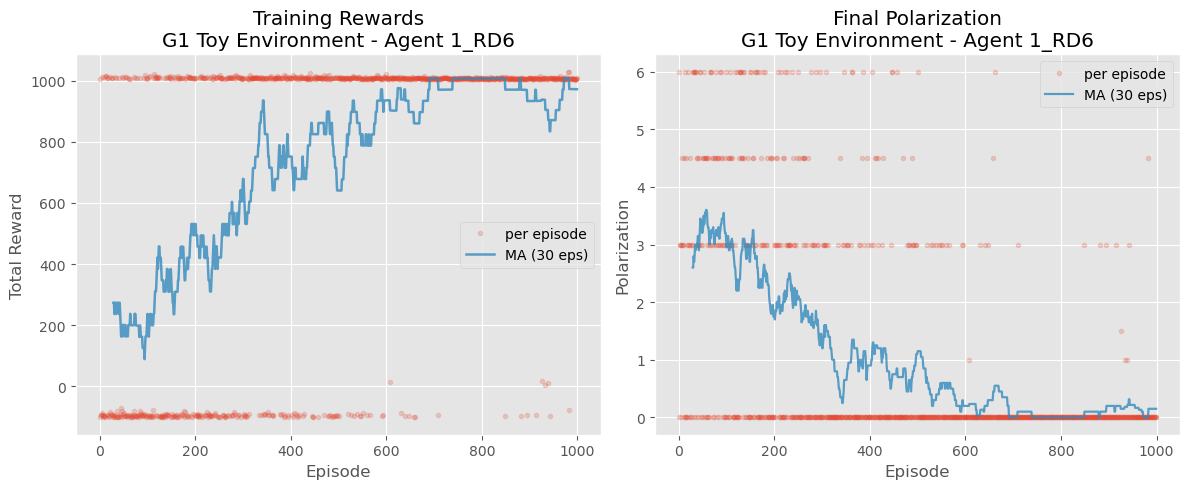


--- Evaluation summary ---
Mean Reward: 1007.19
Mean Final Polarization: 0.00
Mean Episode Length: 10.6 steps
Steps to 10% Polarization Reduction: 3.6 steps
Steps to 50% Polarization Reduction: 5.7 steps
Steps to 90% Polarization Reduction: 10.6 steps

--- Evaluation plots ---


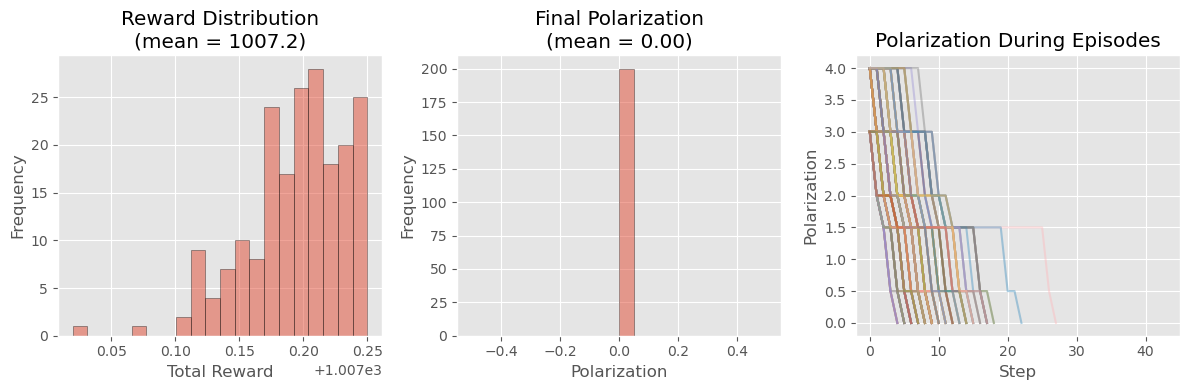

In [40]:
env_1_RD6 = NetworkEnvironment(N=6, graph_type='specific', specific_initial_graph=G1)
env_1_RD6.reset(regenerate_graph=False)
state_size = env_1_RD6.N
initial_action_size = len(env_1_RD6.actions)
initial_total_polarization = env_1_RD6.get_total_polarization()
print("Cross-validate with image for G1 graph in the beginnind of the notebook:")
print(f"State size: {state_size}, Action size: {initial_action_size}, Initial Total Polarization: {initial_total_polarization}")

agent_1_RD6 = DQNAgent(state_size, initial_action_size)
train_1_RD6 = train_dqn_agent(env_1_RD6, agent_1_RD6, env_name='G1 Toy Environment', agent_name='Agent 1_RD6')
plot_training_progress(train_1_RD6)

eval_1_RD6 = evaluate_agent(env_1_RD6, agent_1_RD6)
plot_evaluation_results(eval_1_RD6)

Cross-validate with image for G2 graph in the beginnind of the notebook:
State size: 6, Action size: 12, Initial Total Polarization: 5.0

Starting training for 1000 episodes...
Episode: 100/1000, Reward: -98.70, Epsilon: 0.82, Initial Polarization: 5.0, Steps: 40, Final Polarization: 6.00
Episode: 200/1000, Reward: -88.96, Epsilon: 0.67, Initial Polarization: 5.0, Steps: 196, Final Polarization: 3.00
Episode: 300/1000, Reward: -93.21, Epsilon: 0.55, Initial Polarization: 5.0, Steps: 221, Final Polarization: 3.00
Episode: 400/1000, Reward: 1010.53, Epsilon: 0.45, Initial Polarization: 5.0, Steps: 67, Final Polarization: 0.00
Episode: 500/1000, Reward: 1008.93, Epsilon: 0.37, Initial Polarization: 5.0, Steps: 77, Final Polarization: 0.00
Episode: 600/1000, Reward: 1010.47, Epsilon: 0.30, Initial Polarization: 5.0, Steps: 73, Final Polarization: 0.00
Episode: 700/1000, Reward: 1009.30, Epsilon: 0.25, Initial Polarization: 5.0, Steps: 30, Final Polarization: 0.00
Episode: 800/1000, Reward:

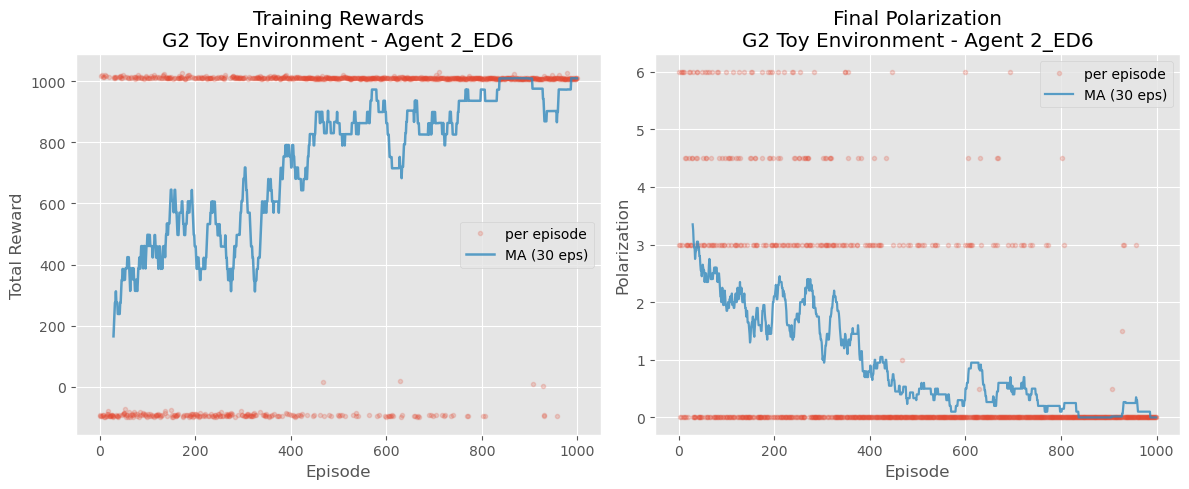


--- Evaluation summary ---
Mean Reward: 1008.87
Mean Final Polarization: 0.00
Mean Episode Length: 13.4 steps
Steps to 10% Polarization Reduction: 3.2 steps
Steps to 50% Polarization Reduction: 7.7 steps
Steps to 90% Polarization Reduction: 12.3 steps

--- Evaluation plots ---


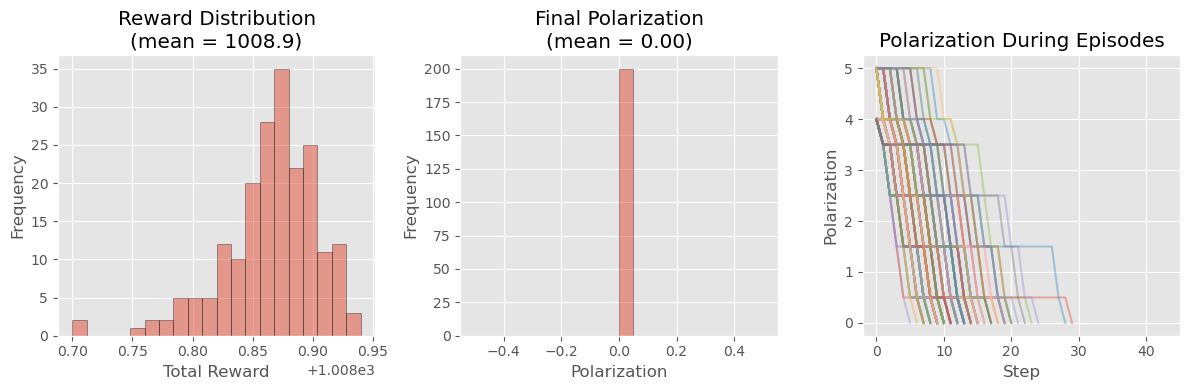

In [41]:
env_2_ED6 = NetworkEnvironment(N=6, graph_type='specific', specific_initial_graph=G2)
env_2_ED6.reset(regenerate_graph=False)
state_size = env_2_ED6.N
initial_action_size = len(env_2_ED6.actions)
initial_total_polarization = env_2_ED6.get_total_polarization()
print("Cross-validate with image for G2 graph in the beginnind of the notebook:")
print(f"State size: {state_size}, Action size: {initial_action_size}, Initial Total Polarization: {initial_total_polarization}")

agent_2_ED6 = DQNAgent(state_size, initial_action_size)
train_2_ED6 = train_dqn_agent(env_2_ED6, agent_2_ED6, env_name='G2 Toy Environment', agent_name='Agent 2_ED6')
plot_training_progress(train_2_ED6)

eval_2_ED6 = evaluate_agent(env_2_ED6, agent_2_ED6)
plot_evaluation_results(eval_2_ED6)

Cross-validate with image for GB graph in the beginnind of the notebook:
State size: 8, Action size: 16, Initial Total Polarization: 6.0

Starting training for 1000 episodes...
Episode: 100/1000, Reward: -91.36, Epsilon: 0.82, Initial Polarization: 6.0, Steps: 146, Final Polarization: 4.00
Episode: 200/1000, Reward: -87.85, Epsilon: 0.67, Initial Polarization: 6.0, Steps: 365, Final Polarization: 4.00
Episode: 300/1000, Reward: 1013.37, Epsilon: 0.55, Initial Polarization: 6.0, Steps: 73, Final Polarization: 0.00
Episode: 400/1000, Reward: 1010.91, Epsilon: 0.45, Initial Polarization: 6.0, Steps: 39, Final Polarization: 0.00
Episode: 500/1000, Reward: 1014.82, Epsilon: 0.37, Initial Polarization: 6.0, Steps: 208, Final Polarization: 0.00
Episode: 600/1000, Reward: 1011.06, Epsilon: 0.30, Initial Polarization: 6.0, Steps: 24, Final Polarization: 0.00
Episode: 700/1000, Reward: 6.10, Epsilon: 0.25, Initial Polarization: 6.0, Steps: 500, Final Polarization: 3.00
Episode: 800/1000, Reward:

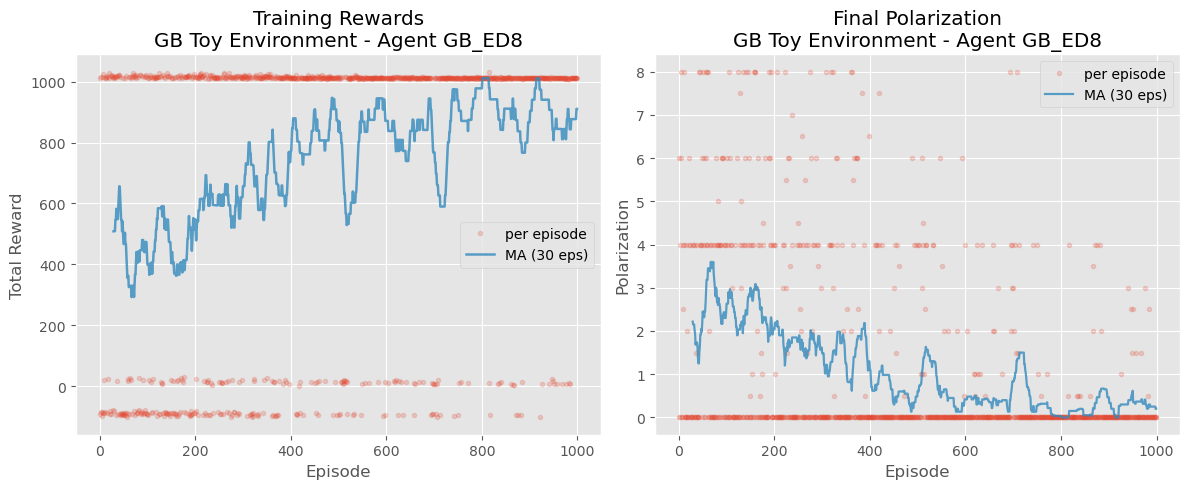


--- Evaluation summary ---
Mean Reward: 1010.54
Mean Final Polarization: 0.00
Mean Episode Length: 15.7 steps
Steps to 10% Polarization Reduction: 3.5 steps
Steps to 50% Polarization Reduction: 9.2 steps
Steps to 90% Polarization Reduction: 14.0 steps

--- Evaluation plots ---


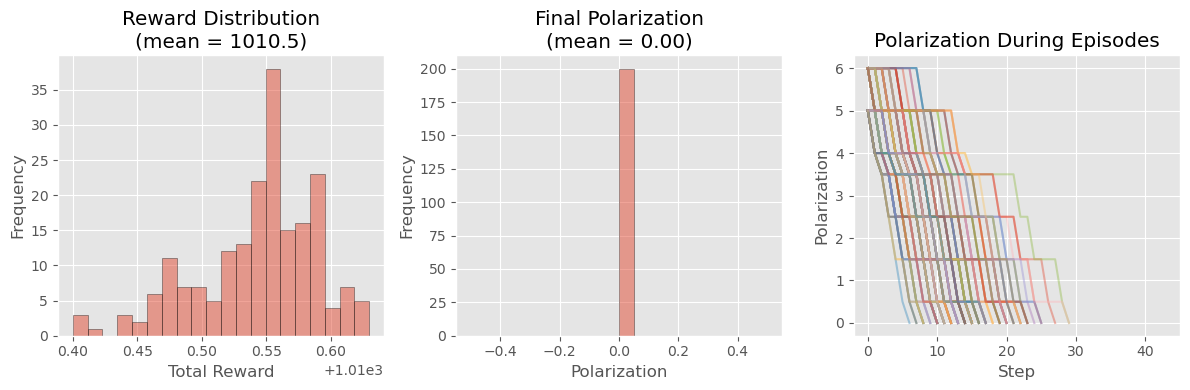

In [34]:
env_GB_ED8 = NetworkEnvironment(N=8, graph_type='specific', specific_initial_graph=GB)
env_GB_ED8.reset(regenerate_graph=False)
state_size = env_GB_ED8.N
initial_action_size = len(env_GB_ED8.actions)
initial_total_polarization = env_GB_ED8.get_total_polarization()
print("Cross-validate with image for GB graph in the beginnind of the notebook:")
print(f"State size: {state_size}, Action size: {initial_action_size}, Initial Total Polarization: {initial_total_polarization}")

agent_GB_ED8 = DQNAgent(state_size, initial_action_size)
train_GB_ED8 = train_dqn_agent(env_GB_ED8, agent_GB_ED8, env_name='GB Toy Environment', agent_name='Agent GB_ED8')
plot_training_progress(train_GB_ED8)

eval_GB_ED8 = evaluate_agent(env_GB_ED8, agent_GB_ED8, regenerate_graph=False)
plot_evaluation_results(eval_GB_ED8)

## Discrete Opinions (N=10)

### Echo Chambers Discrete (ED)


Starting training for 1000 episodes...
Episode: 100/1000, Reward: 1008.47, Epsilon: 0.82, Initial Polarization: 4.50, Steps: 53, Final Polarization: 0.00
Episode: 200/1000, Reward: 1009.32, Epsilon: 0.67, Initial Polarization: 4.50, Steps: 158, Final Polarization: 0.00
Episode: 300/1000, Reward: -89.24, Epsilon: 0.55, Initial Polarization: 4.50, Steps: 384, Final Polarization: 5.00
Episode: 400/1000, Reward: 1009.28, Epsilon: 0.45, Initial Polarization: 4.50, Steps: 332, Final Polarization: 0.00
Episode: 500/1000, Reward: 18.00, Epsilon: 0.37, Initial Polarization: 4.50, Steps: 500, Final Polarization: 5.50
Episode: 600/1000, Reward: 1008.20, Epsilon: 0.30, Initial Polarization: 4.50, Steps: 80, Final Polarization: 0.00
Episode: 700/1000, Reward: 1008.30, Epsilon: 0.25, Initial Polarization: 4.50, Steps: 190, Final Polarization: 0.00
Episode: 800/1000, Reward: 1008.72, Epsilon: 0.20, Initial Polarization: 4.50, Steps: 88, Final Polarization: 0.00
Episode: 900/1000, Reward: 1008.19, Ep

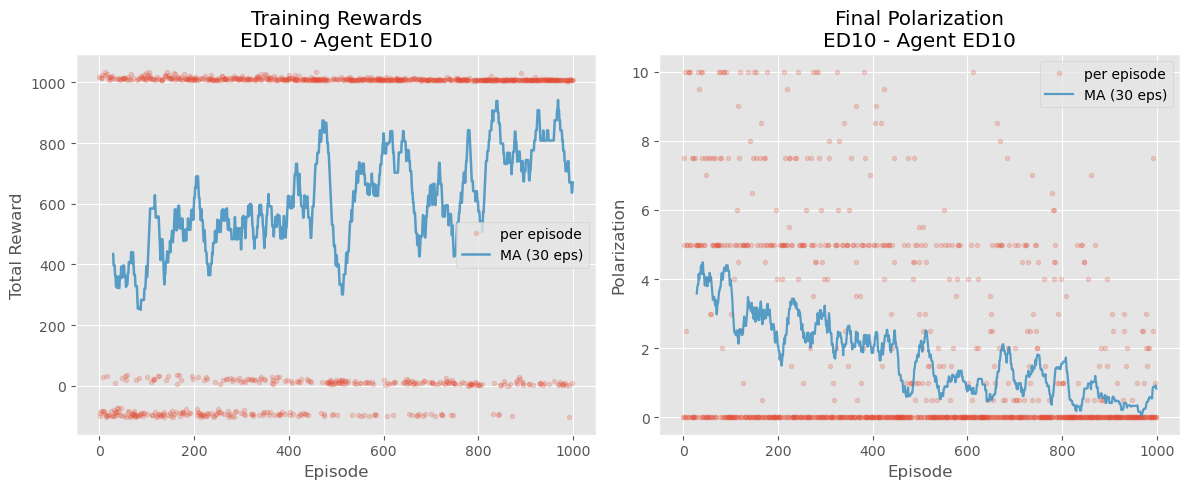


--- Evaluation summary ---
Mean Reward: 1008.27
Mean Final Polarization: 0.00
Mean Episode Length: 12.6 steps
Steps to 10% Polarization Reduction: 3.2 steps
Steps to 50% Polarization Reduction: 6.7 steps
Steps to 90% Polarization Reduction: 12.6 steps

--- Evaluation plots ---


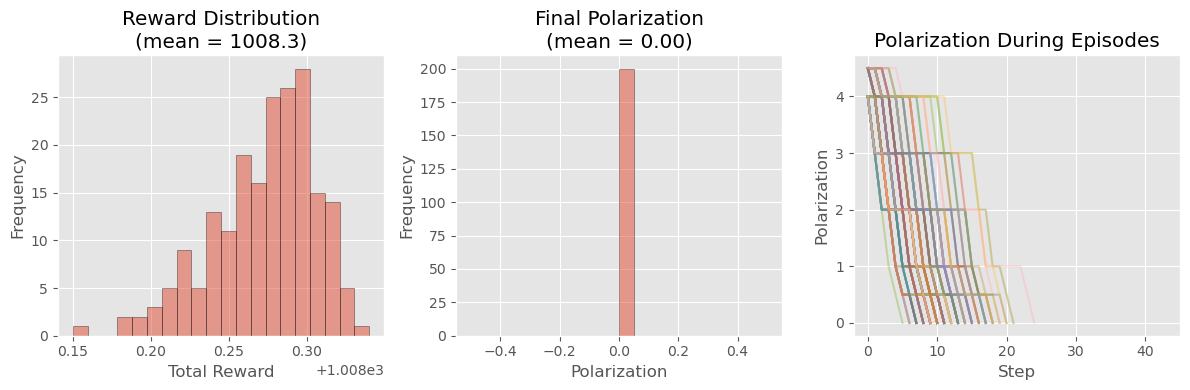

In [41]:
env_ED10 = NetworkEnvironment(N=10, graph_type='echo_chamber', continuous_opinions=False) # echo chamber discrete opinions
env_ED10.reset(regenerate_graph=False)  
state_size = env_ED10.N
initial_action_size = len(env_ED10.actions)

agent_ED10 = DQNAgent(state_size, initial_action_size)
train_ED10 = train_dqn_agent(env_ED10, agent_ED10, env_name='ED10', agent_name='Agent ED10')
plot_training_progress(train_ED10)

eval_ED10 = evaluate_agent(env_ED10, agent_ED10, regenerate_graph=False)
plot_evaluation_results(eval_ED10)

### Random Discrete (RD)


Starting training for 1000 episodes...
Episode: 100/1000, Reward: -91.20, Epsilon: 0.82, Initial Polarization: 6.00, Steps: 280, Final Polarization: 10.00
Episode: 200/1000, Reward: 1017.19, Epsilon: 0.67, Initial Polarization: 6.00, Steps: 171, Final Polarization: 0.00
Episode: 300/1000, Reward: 1018.84, Epsilon: 0.55, Initial Polarization: 6.00, Steps: 186, Final Polarization: 0.00
Episode: 400/1000, Reward: -89.47, Epsilon: 0.45, Initial Polarization: 6.00, Steps: 197, Final Polarization: 5.00
Episode: 500/1000, Reward: 1011.43, Epsilon: 0.37, Initial Polarization: 6.00, Steps: 67, Final Polarization: 0.00
Episode: 600/1000, Reward: 19.90, Epsilon: 0.30, Initial Polarization: 6.00, Steps: 500, Final Polarization: 2.00
Episode: 700/1000, Reward: 5.10, Epsilon: 0.25, Initial Polarization: 6.00, Steps: 500, Final Polarization: 4.00
Episode: 800/1000, Reward: 9.80, Epsilon: 0.20, Initial Polarization: 6.00, Steps: 500, Final Polarization: 1.50
Episode: 900/1000, Reward: 1008.59, Epsilo

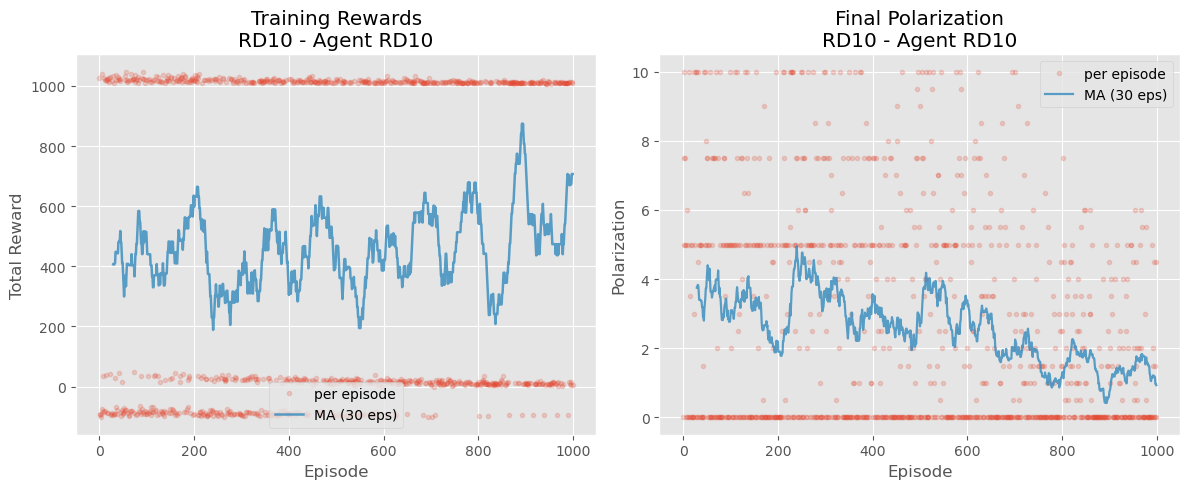

C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



--- Evaluation summary ---
Mean Reward: 6.78
Mean Final Polarization: 1.50
Mean Episode Length: 200.0 steps
Steps to 10% Polarization Reduction: 5.6 steps
Steps to 50% Polarization Reduction: 14.5 steps
Steps to 90% Polarization Reduction: nan steps

--- Evaluation plots ---


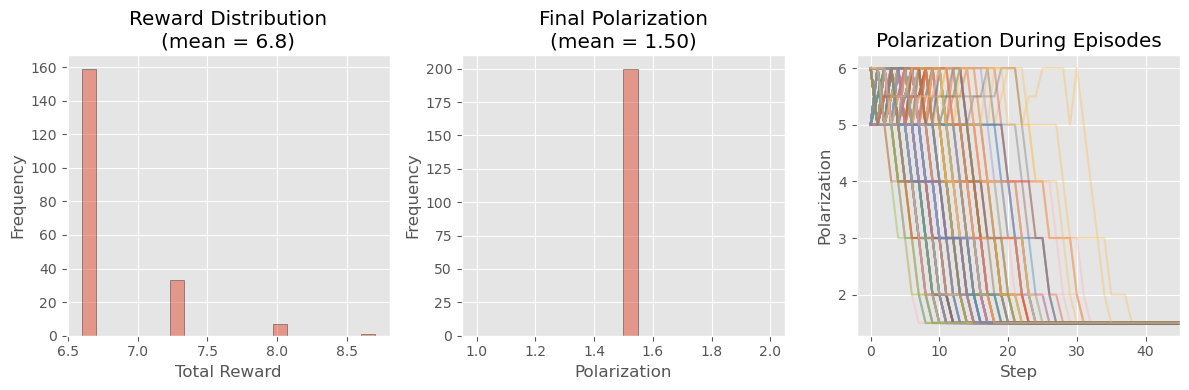

In [37]:
env_RD10 = NetworkEnvironment(N=10, graph_type='random', continuous_opinions=False)
env_RD10.reset(regenerate_graph=False)
state_size = env_RD10.N
initial_action_size = len(env_RD10.actions)

agent_RD10 = DQNAgent(state_size, initial_action_size)
train_results = train_dqn_agent(env_RD10, agent_RD10, env_name='RD10', agent_name='Agent RD10')
plot_training_progress(train_results)
eval_results = evaluate_agent(env_RD10, agent_RD10, max_steps=200, regenerate_graph=False)
plot_evaluation_results(eval_results)

## "Continuous" opinions (N=10)

### Echo Chambers (EC)


Starting training for 1000 episodes...
Episode: 100/1000, Reward: -74.67, Epsilon: 0.82, Initial Polarization: 4.91, Steps: 362, Final Polarization: 2.70
Episode: 200/1000, Reward: -92.46, Epsilon: 0.67, Initial Polarization: 4.91, Steps: 79, Final Polarization: 5.80
Episode: 300/1000, Reward: 1017.55, Epsilon: 0.55, Initial Polarization: 4.91, Steps: 175, Final Polarization: 0.10
Episode: 400/1000, Reward: 10.65, Epsilon: 0.45, Initial Polarization: 4.91, Steps: 500, Final Polarization: 4.03
Episode: 500/1000, Reward: 1012.70, Epsilon: 0.37, Initial Polarization: 4.91, Steps: 180, Final Polarization: 0.10
Episode: 600/1000, Reward: -93.03, Epsilon: 0.30, Initial Polarization: 4.91, Steps: 118, Final Polarization: 3.69
Episode: 700/1000, Reward: -87.56, Epsilon: 0.25, Initial Polarization: 4.91, Steps: 484, Final Polarization: 9.13
Episode: 800/1000, Reward: 14.94, Epsilon: 0.20, Initial Polarization: 4.91, Steps: 500, Final Polarization: 5.48
Episode: 900/1000, Reward: 14.80, Epsilon

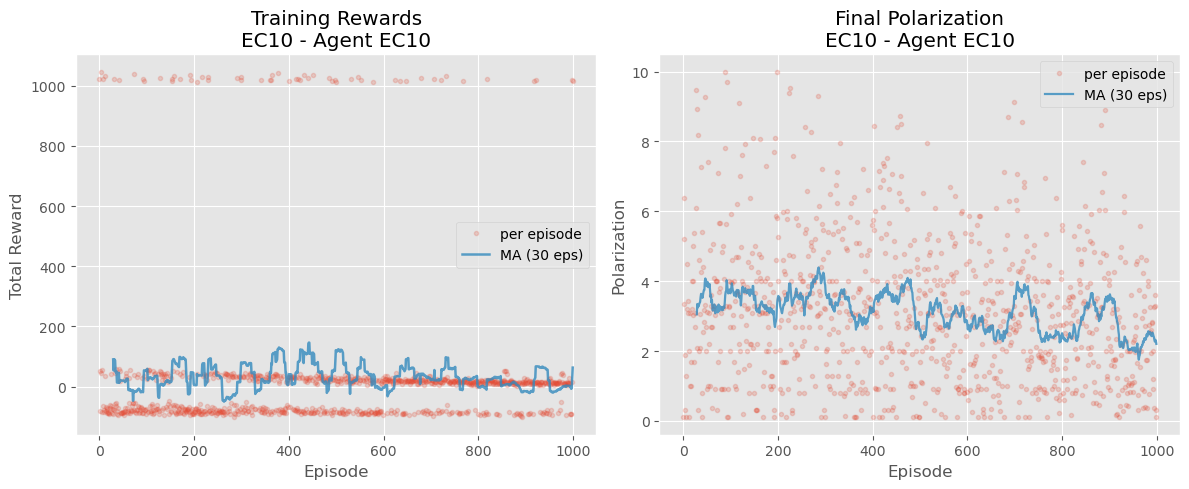

C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



--- Evaluation summary ---
Mean Reward: 2.67
Mean Final Polarization: 3.31
Mean Episode Length: 200.0 steps
Steps to 10% Polarization Reduction: 5.2 steps
Steps to 50% Polarization Reduction: nan steps
Steps to 90% Polarization Reduction: nan steps

--- Evaluation plots ---


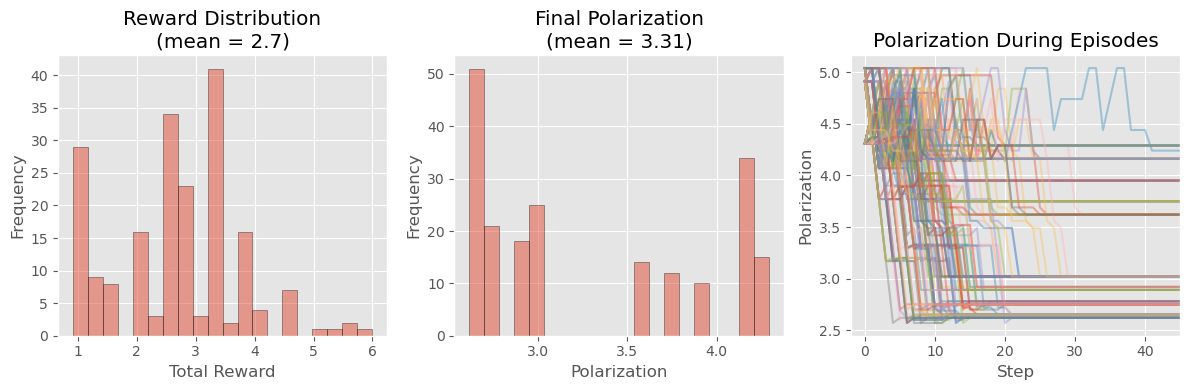

In [38]:
env_EC10 = NetworkEnvironment(N=10, graph_type='random', continuous_opinions=True)
env_EC10.reset(regenerate_graph=False)
state_size = env_EC10.N
initial_action_size = len(env_EC10.actions)

agent_EC10 = DQNAgent(state_size, initial_action_size)
train_results = train_dqn_agent(env_EC10, agent_EC10, env_name='EC10', agent_name='Agent EC10')
plot_training_progress(train_results)
eval_results = evaluate_agent(env_EC10, agent_EC10, max_steps=200, regenerate_graph=False)
plot_evaluation_results(eval_results)

### Random (RC)


Starting training for 1000 episodes...
Episode: 100/1000, Reward: 39.88, Epsilon: 0.82, Initial Polarization: 4.81, Steps: 500, Final Polarization: 3.46
Episode: 200/1000, Reward: -93.99, Epsilon: 0.67, Initial Polarization: 4.81, Steps: 79, Final Polarization: 4.75
Episode: 300/1000, Reward: -88.29, Epsilon: 0.55, Initial Polarization: 4.81, Steps: 98, Final Polarization: 3.10
Episode: 400/1000, Reward: 20.48, Epsilon: 0.45, Initial Polarization: 4.81, Steps: 500, Final Polarization: 1.90
Episode: 500/1000, Reward: 13.27, Epsilon: 0.37, Initial Polarization: 4.81, Steps: 500, Final Polarization: 2.28
Episode: 600/1000, Reward: 13.38, Epsilon: 0.30, Initial Polarization: 4.81, Steps: 500, Final Polarization: 2.56
Episode: 700/1000, Reward: 18.32, Epsilon: 0.25, Initial Polarization: 4.81, Steps: 500, Final Polarization: 1.10
Episode: 800/1000, Reward: 16.75, Epsilon: 0.20, Initial Polarization: 4.81, Steps: 500, Final Polarization: 1.42
Episode: 900/1000, Reward: 12.89, Epsilon: 0.17,

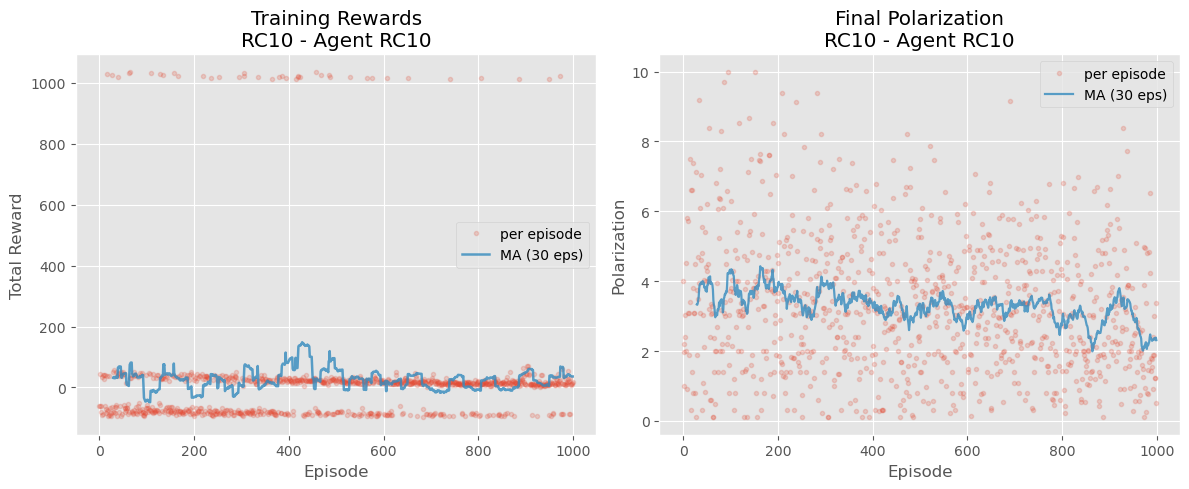

C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



--- Evaluation summary ---
Mean Reward: 5.06
Mean Final Polarization: 2.87
Mean Episode Length: 200.0 steps
Steps to 10% Polarization Reduction: 5.8 steps
Steps to 50% Polarization Reduction: 20.4 steps
Steps to 90% Polarization Reduction: nan steps

--- Evaluation plots ---


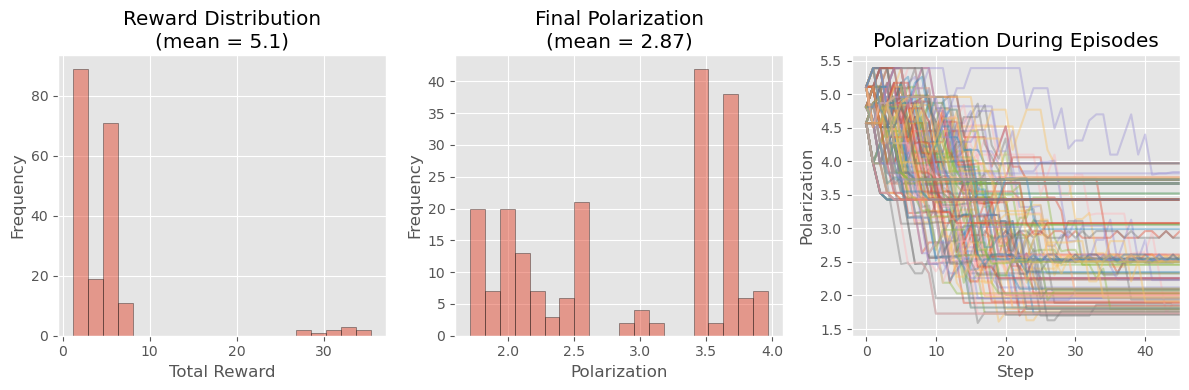

In [39]:
env_RC10 = NetworkEnvironment(N=10, graph_type='random', continuous_opinions=True)
env_RC10.reset(regenerate_graph=False)
state_size = env_RC10.N
initial_action_size = len(env_RC10.actions)

agent_RC10 = DQNAgent(state_size, initial_action_size)
train_results = train_dqn_agent(env_RC10, agent_RC10, env_name='RC10', agent_name='Agent RC10')
plot_training_progress(train_results)
eval_results = evaluate_agent(env_RC10, agent_RC10, max_steps=200, regenerate_graph=False)
plot_evaluation_results(eval_results)

## N = 40


Starting training for 1000 episodes...
Episode: 100/1000, Reward: 54.90, Epsilon: 0.82, Initial Polarization: 23.50, Steps: 500, Final Polarization: 17.00
Episode: 200/1000, Reward: 48.80, Epsilon: 0.67, Initial Polarization: 23.50, Steps: 500, Final Polarization: 11.00
Episode: 300/1000, Reward: 30.70, Epsilon: 0.55, Initial Polarization: 23.50, Steps: 500, Final Polarization: 15.00
Episode: 400/1000, Reward: 29.60, Epsilon: 0.45, Initial Polarization: 23.50, Steps: 500, Final Polarization: 18.00
Episode: 500/1000, Reward: 23.10, Epsilon: 0.37, Initial Polarization: 23.50, Steps: 500, Final Polarization: 21.00
Episode: 600/1000, Reward: 17.10, Epsilon: 0.30, Initial Polarization: 23.50, Steps: 500, Final Polarization: 19.50
Episode: 700/1000, Reward: 16.00, Epsilon: 0.25, Initial Polarization: 23.50, Steps: 500, Final Polarization: 23.00
Episode: 800/1000, Reward: 18.30, Epsilon: 0.20, Initial Polarization: 23.50, Steps: 500, Final Polarization: 20.00
Episode: 900/1000, Reward: 11.20

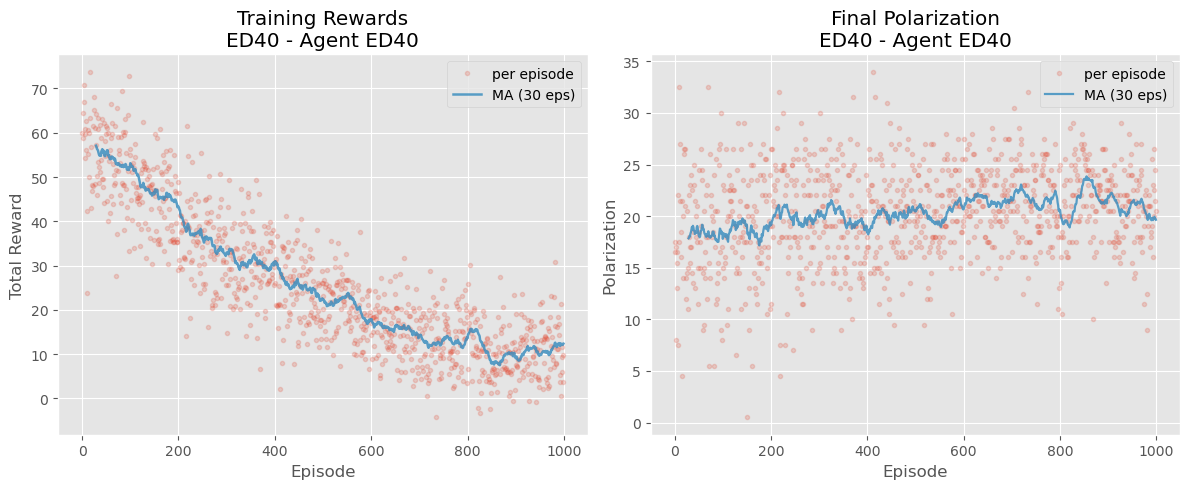

C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



--- Evaluation summary ---
Mean Reward: -5.00
Mean Final Polarization: 23.50
Mean Episode Length: 500.0 steps
Steps to 10% Polarization Reduction: nan steps
Steps to 50% Polarization Reduction: nan steps
Steps to 90% Polarization Reduction: nan steps

--- Evaluation plots ---


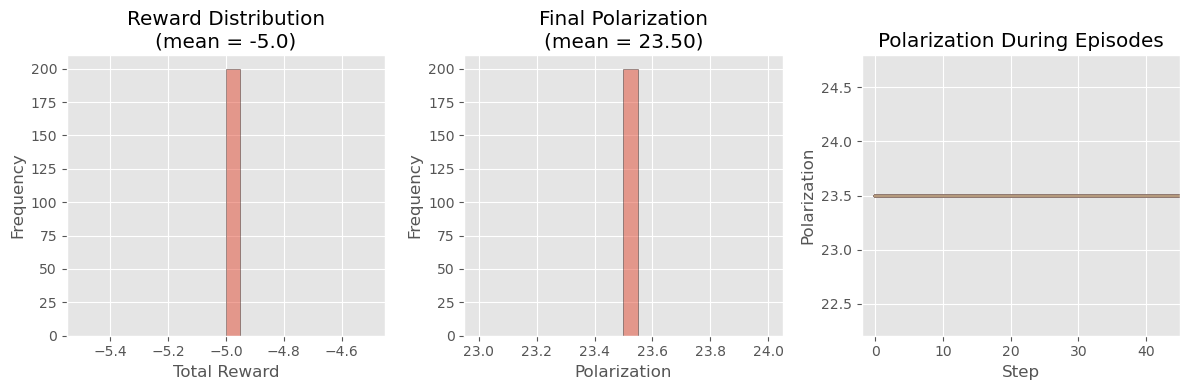

In [42]:
env_ED40 = NetworkEnvironment(N=40, graph_type='echo_chamber', continuous_opinions=False) # echo chamber discrete opinions
env_ED40.reset(regenerate_graph=False)  
state_size = env_ED40.N
initial_action_size = len(env_ED40.actions)

agent_ED40 = DQNAgent(state_size, initial_action_size)
train_ED40 = train_dqn_agent(env_ED40, agent_ED40, env_name='ED40', agent_name='Agent ED40')
plot_training_progress(train_ED40)

eval_ED40 = evaluate_agent(env_ED40, agent_ED40, regenerate_graph=False)
plot_evaluation_results(eval_ED40)


Starting training for 1000 episodes...
Episode: 100/1000, Reward: 46.90, Epsilon: 0.82, Initial Polarization: 23.50, Steps: 500, Final Polarization: 22.50
Episode: 200/1000, Reward: 38.80, Epsilon: 0.67, Initial Polarization: 23.50, Steps: 500, Final Polarization: 22.00
Episode: 300/1000, Reward: 33.10, Epsilon: 0.55, Initial Polarization: 23.50, Steps: 500, Final Polarization: 19.00
Episode: 400/1000, Reward: 14.70, Epsilon: 0.45, Initial Polarization: 23.50, Steps: 500, Final Polarization: 24.50
Episode: 500/1000, Reward: 19.10, Epsilon: 0.37, Initial Polarization: 23.50, Steps: 500, Final Polarization: 22.50
Episode: 600/1000, Reward: 17.30, Epsilon: 0.30, Initial Polarization: 23.50, Steps: 500, Final Polarization: 20.50
Episode: 700/1000, Reward: 25.90, Epsilon: 0.25, Initial Polarization: 23.50, Steps: 500, Final Polarization: 16.50
Episode: 800/1000, Reward: 17.80, Epsilon: 0.20, Initial Polarization: 23.50, Steps: 500, Final Polarization: 16.00
Episode: 900/1000, Reward: 13.40

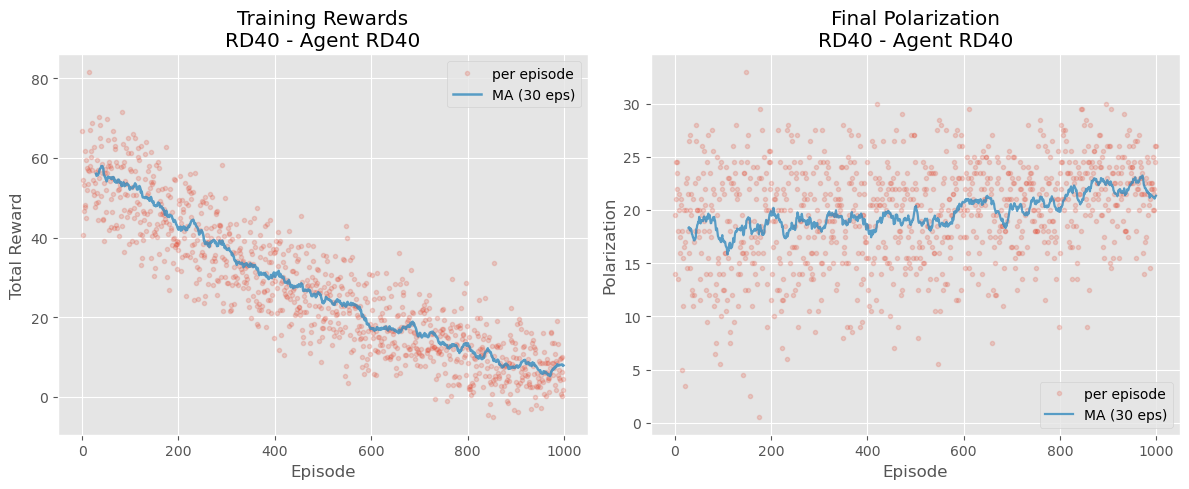

C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\camen\anaconda3\envs\rl_socialnet\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



--- Evaluation summary ---
Mean Reward: -0.30
Mean Final Polarization: 22.50
Mean Episode Length: 200.0 steps
Steps to 10% Polarization Reduction: nan steps
Steps to 50% Polarization Reduction: nan steps
Steps to 90% Polarization Reduction: nan steps

--- Evaluation plots ---


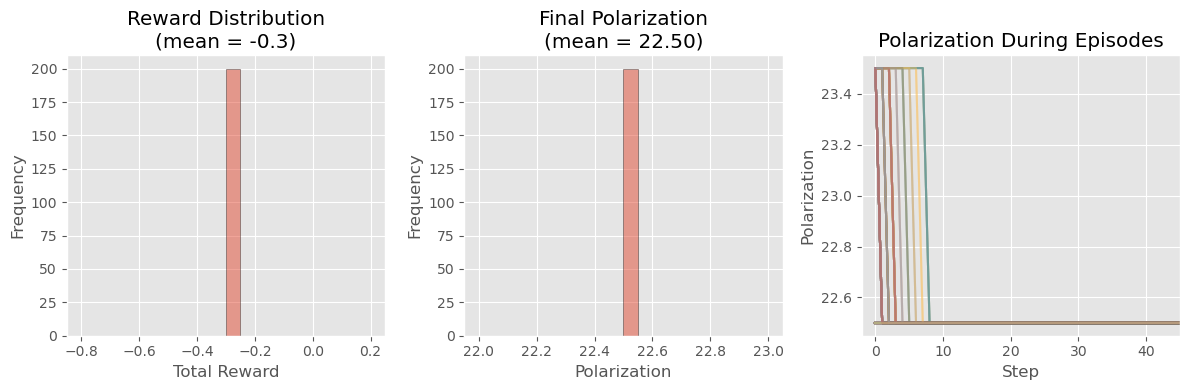

In [43]:
env_RD40 = NetworkEnvironment(N=40, graph_type='random', continuous_opinions=False)
env_RD40.reset(regenerate_graph=False)
state_size = env_RD40.N
initial_action_size = len(env_RD40.actions)

agent_RD40 = DQNAgent(state_size, initial_action_size)
train_results = train_dqn_agent(env_RD40, agent_RD40, env_name='RD40', agent_name='Agent RD40')
plot_training_progress(train_results)
eval_results = evaluate_agent(env_RD40, agent_RD40, max_steps=200, regenerate_graph=False)
plot_evaluation_results(eval_results)

# Bigger experiments (N=8, num_episodes=10,000)

In [51]:
raise RuntimeError("The following experiments are still under construction. In some of them, the environment is generating new graphs, so the DQN Agent is mostly lost with no other information. In the working is injection of adjacency awareness, however this project's time limit did not allow for it.")


RuntimeError: The following experiments are still under construction. In some of them, the environment is generating new graphs, so the DQN Agent is mostly lost with no other information. In the working is injection of adjacency awareness, however this project's time limit did not allow for it.


Starting training for 10000 episodes...
episode: 100/10000, score: -88.76, Epsilon: 0.82, Steps: 216, Final Polarization: 4.00
episode: 200/10000, score: 1016.21, Epsilon: 0.67, Steps: 239, Final Polarization: 0.00
episode: 300/10000, score: 1018.96, Epsilon: 0.55, Steps: 434, Final Polarization: 0.00
episode: 400/10000, score: 1013.72, Epsilon: 0.45, Steps: 108, Final Polarization: 0.00
episode: 500/10000, score: 1011.80, Epsilon: 0.37, Steps: 120, Final Polarization: 0.00
episode: 600/10000, score: 1011.45, Epsilon: 0.30, Steps: 115, Final Polarization: 0.00
episode: 700/10000, score: -90.15, Epsilon: 0.25, Steps: 165, Final Polarization: 4.00
episode: 800/10000, score: 3.10, Epsilon: 0.20, Steps: 500, Final Polarization: 5.00
episode: 900/10000, score: 6.30, Epsilon: 0.17, Steps: 500, Final Polarization: 2.00
episode: 1000/10000, score: 1013.45, Epsilon: 0.14, Steps: 235, Final Polarization: 0.00
episode: 1100/10000, score: 1011.60, Epsilon: 0.11, Steps: 30, Final Polarization: 0.0

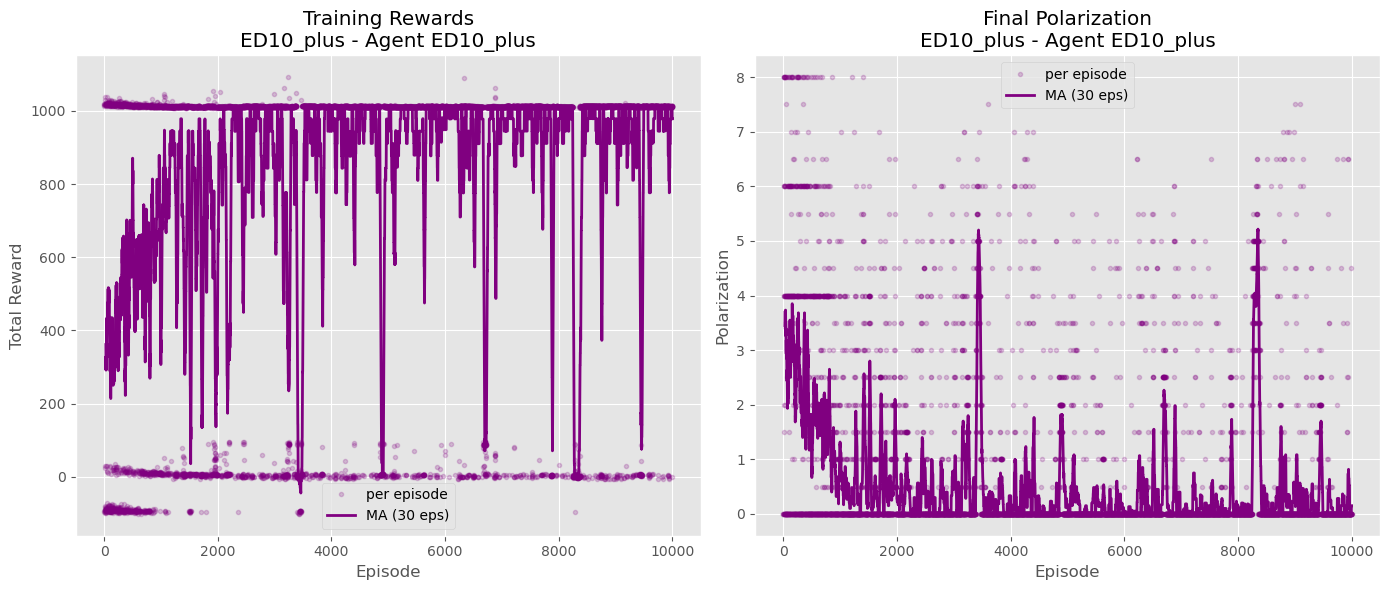


--- Evaluation plots ---


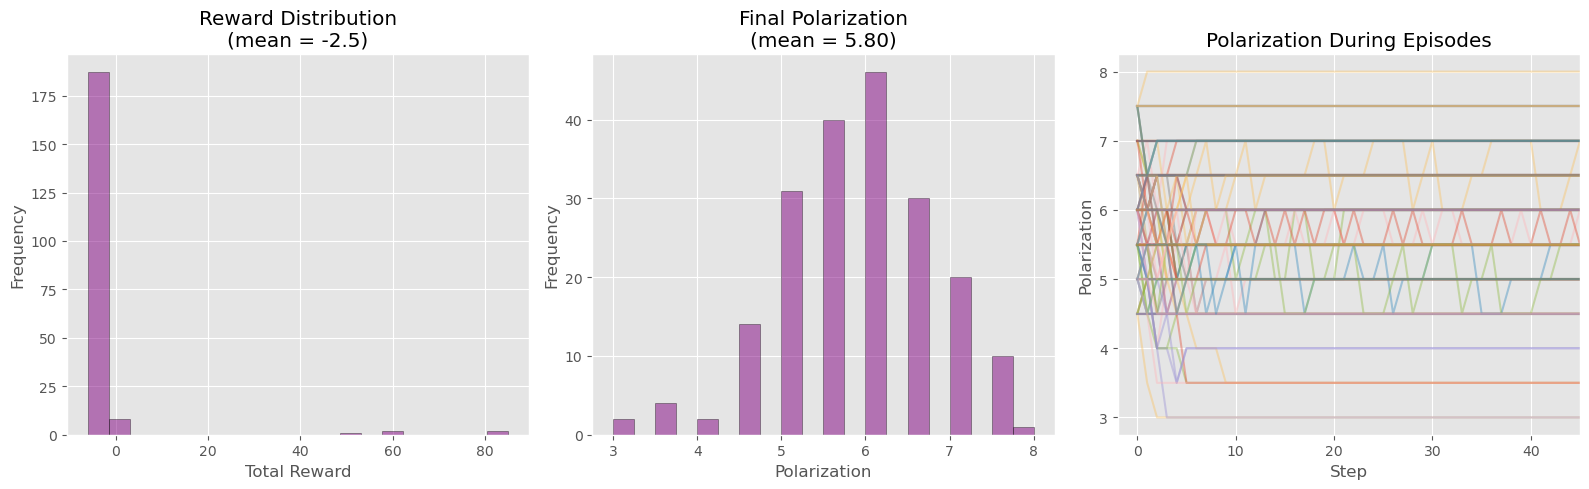

In [37]:
env_ED8_plus = NetworkEnvironment(N=8, graph_type='echo_chamber', continuous_opinions=False) # echo chamber discrete opinions
env_ED8_plus.reset(regenerate_graph=True)  
state_size = env_ED8_plus.N
initial_action_size = len(env_ED8_plus.actions)

agent_ED8_plus = DQNAgent(state_size, initial_action_size)
train_ED8_plus = train_dqn_agent(env_ED8_plus, agent_ED8_plus, env_name='ED8_plus', agent_name='Agent ED8_plus', episodes=10000)
plot_training_progress(train_ED8_plus)

eval_ED8_plus = evaluate_agent(env_ED8_plus, agent_ED8_plus)
plot_evaluation_results(eval_ED8_plus)


Starting training for 10000 episodes...
episode: 100/10000, score: -90.22, Epsilon: 0.82, Steps: 172, Final Polarization: 8.00
episode: 200/10000, score: 1016.88, Epsilon: 0.67, Steps: 132, Final Polarization: 0.00
episode: 300/10000, score: -93.98, Epsilon: 0.55, Steps: 148, Final Polarization: 8.00
episode: 400/10000, score: 1013.87, Epsilon: 0.45, Steps: 73, Final Polarization: 0.00
episode: 500/10000, score: 15.30, Epsilon: 0.37, Steps: 500, Final Polarization: 2.00
episode: 600/10000, score: -81.63, Epsilon: 0.30, Steps: 243, Final Polarization: 4.00
episode: 700/10000, score: 1010.89, Epsilon: 0.25, Steps: 41, Final Polarization: 0.00
episode: 800/10000, score: 1011.00, Epsilon: 0.20, Steps: 30, Final Polarization: 0.00
episode: 900/10000, score: 1014.32, Epsilon: 0.17, Steps: 248, Final Polarization: 0.00
episode: 1000/10000, score: 1010.68, Epsilon: 0.14, Steps: 62, Final Polarization: 0.00
episode: 1100/10000, score: 8.40, Epsilon: 0.11, Steps: 500, Final Polarization: 1.00
e

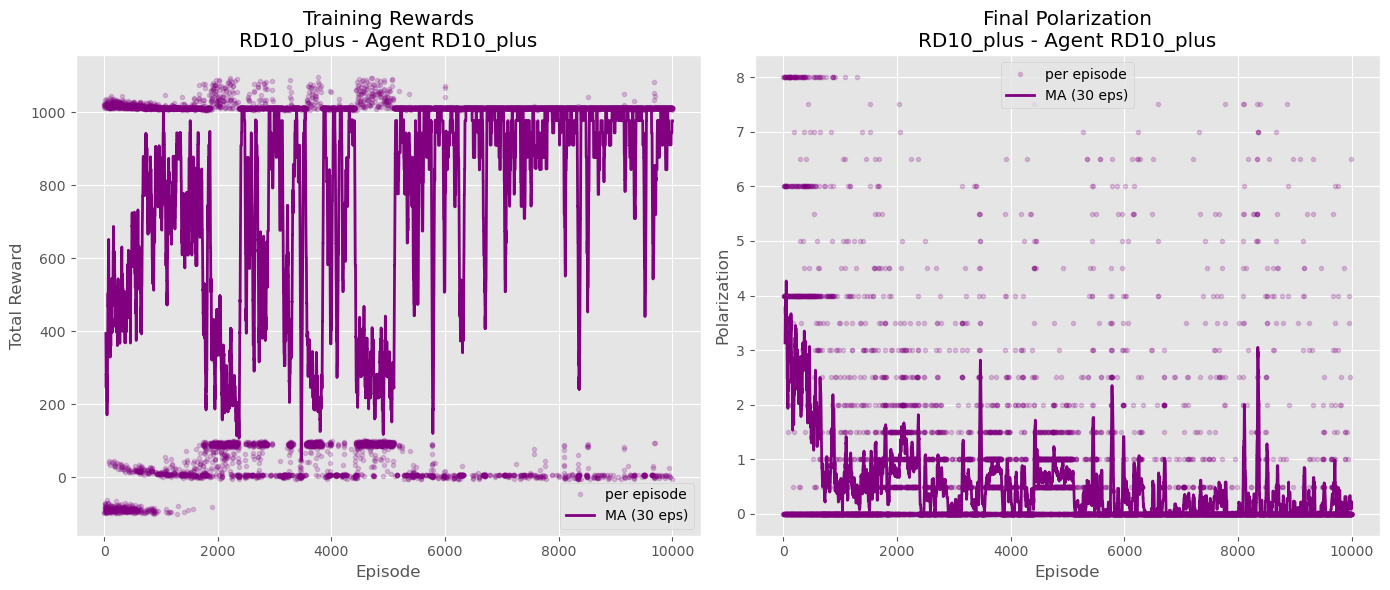


--- Evaluation plots ---


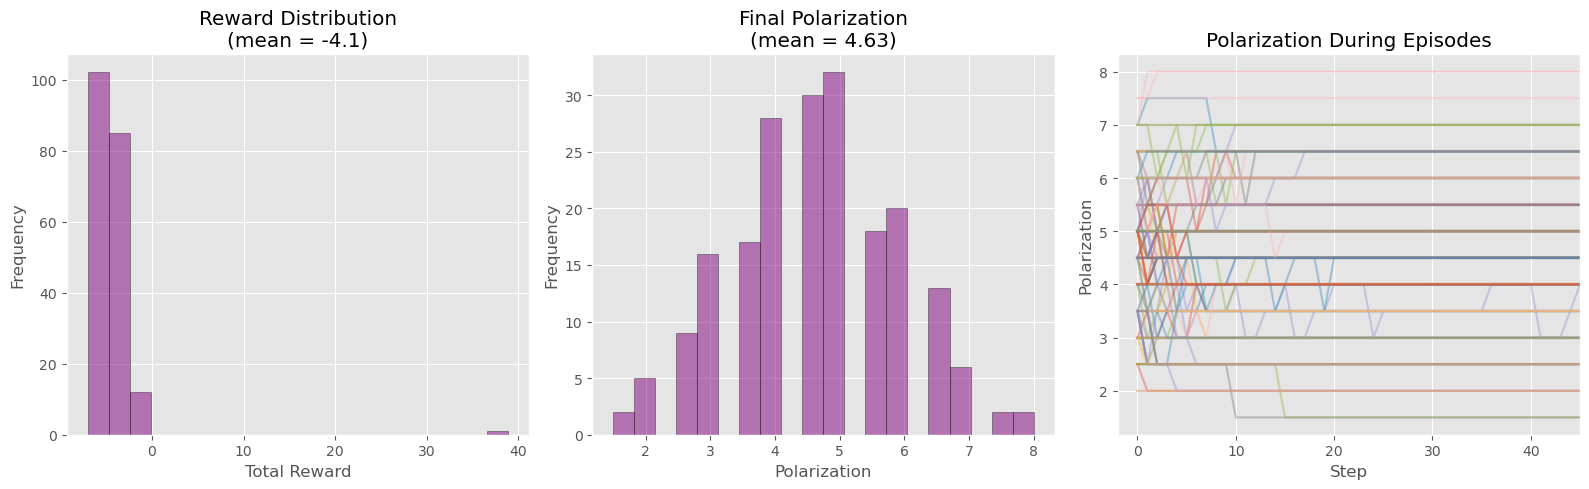

In [38]:
env_RD8_plus = NetworkEnvironment(N=8, graph_type='random', continuous_opinions=False) # echo chamber discrete opinions
env_RD8_plus.reset(regenerate_graph=True)  
state_size = env_RD8_plus.N
initial_action_size = len(env_RD8_plus.actions)

agent_RD8_plus = DQNAgent(state_size, initial_action_size)
train_RD8_plus = train_dqn_agent(env_RD8_plus, agent_RD8_plus, env_name='RD8_plus', agent_name='Agent RD8_plus', episodes=10000)
plot_training_progress(train_RD8_plus)

eval_RD8_plus = evaluate_agent(env_RD8_plus, agent_RD8_plus)
plot_evaluation_results(eval_RD8_plus)


Starting training for 10000 episodes...
episode: 100/10000, score: 4.97, Epsilon: 0.82, Steps: 500, Final Polarization: 1.07
episode: 200/10000, score: 32.71, Epsilon: 0.67, Steps: 500, Final Polarization: 4.90
episode: 300/10000, score: -73.38, Epsilon: 0.55, Steps: 414, Final Polarization: 0.80
episode: 400/10000, score: -77.64, Epsilon: 0.45, Steps: 316, Final Polarization: 2.70
episode: 500/10000, score: -63.55, Epsilon: 0.37, Steps: 389, Final Polarization: 3.11
episode: 600/10000, score: 14.29, Epsilon: 0.30, Steps: 500, Final Polarization: 1.37
episode: 700/10000, score: 68.64, Epsilon: 0.25, Steps: 500, Final Polarization: 2.13
episode: 800/10000, score: 13.75, Epsilon: 0.20, Steps: 500, Final Polarization: 1.08
episode: 900/10000, score: 19.45, Epsilon: 0.17, Steps: 500, Final Polarization: 1.08
episode: 1000/10000, score: 64.65, Epsilon: 0.14, Steps: 500, Final Polarization: 4.05
episode: 1100/10000, score: -96.58, Epsilon: 0.11, Steps: 378, Final Polarization: 2.60
episode:

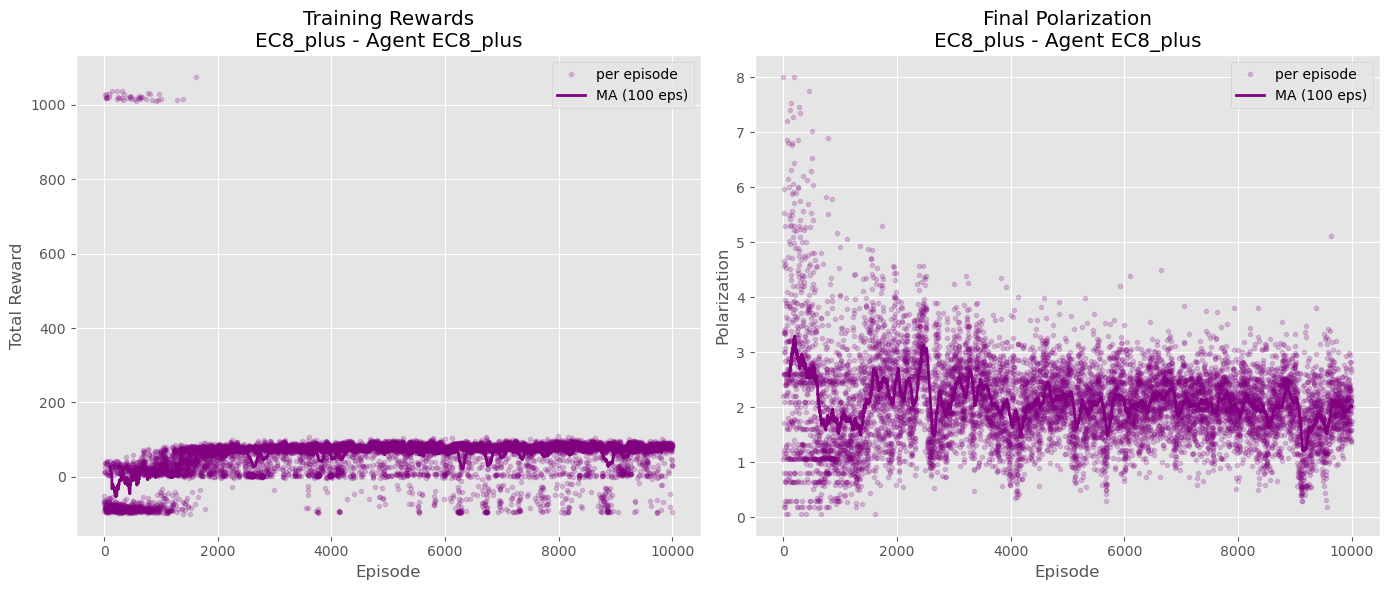


--- Evaluation plots ---


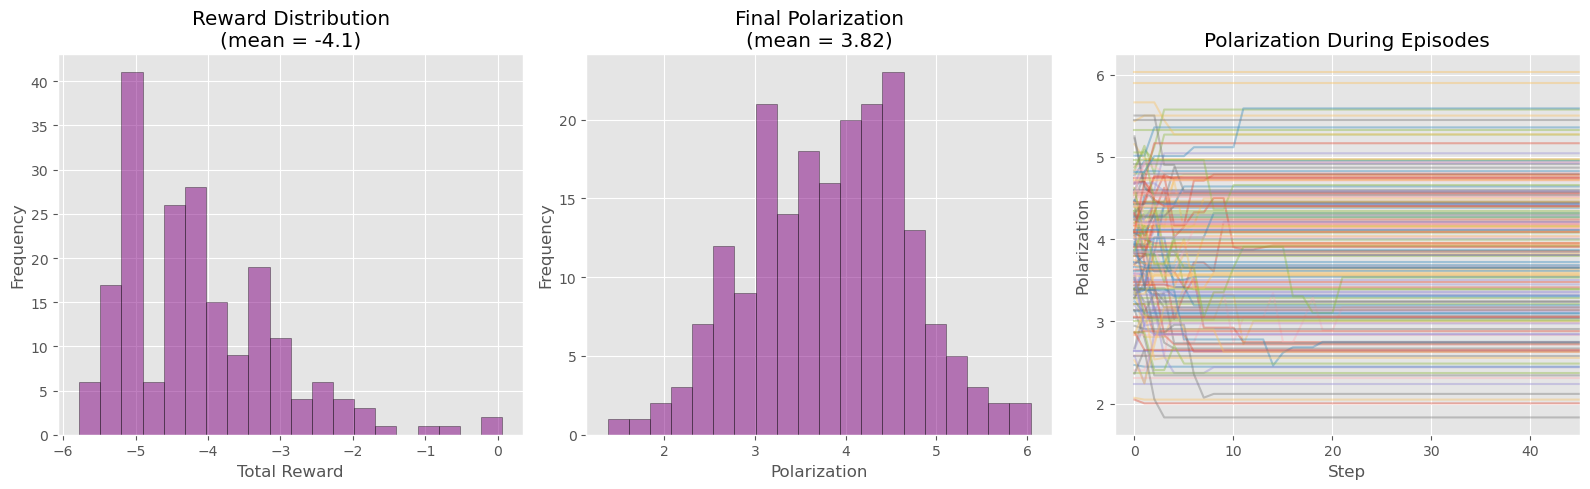

In [40]:
env_EC8_plus = NetworkEnvironment(N=8, graph_type='echo_chamber', continuous_opinions=True) # echo chamber discrete opinions
env_EC8_plus.reset(regenerate_graph=True)  
state_size = env_EC8_plus.N
initial_action_size = len(env_EC8_plus.actions)

agent_EC8_plus = DQNAgent(state_size, initial_action_size)
train_EC8_plus = train_dqn_agent(env_EC8_plus, agent_EC8_plus, env_name='EC8_plus', agent_name='Agent EC8_plus', episodes=10000)
plot_training_progress(train_EC8_plus, window_size=100)

eval_EC8_plus = evaluate_agent(env_EC8_plus, agent_EC8_plus)
plot_evaluation_results(eval_EC8_plus)


Starting training for 10000 episodes...
episode: 100/10000, score: -98.85, Epsilon: 0.82, Steps: 36, Final Polarization: 5.62
episode: 200/10000, score: -92.63, Epsilon: 0.67, Steps: 53, Final Polarization: 3.00
episode: 300/10000, score: -74.25, Epsilon: 0.55, Steps: 371, Final Polarization: 3.20
episode: 400/10000, score: 15.46, Epsilon: 0.45, Steps: 500, Final Polarization: 1.07
episode: 500/10000, score: 14.93, Epsilon: 0.37, Steps: 500, Final Polarization: 1.24
episode: 600/10000, score: -74.31, Epsilon: 0.30, Steps: 484, Final Polarization: 3.68
episode: 700/10000, score: 37.55, Epsilon: 0.25, Steps: 500, Final Polarization: 4.54
episode: 800/10000, score: 34.18, Epsilon: 0.20, Steps: 500, Final Polarization: 1.20
episode: 900/10000, score: 9.16, Epsilon: 0.17, Steps: 500, Final Polarization: 1.36
episode: 1000/10000, score: -72.77, Epsilon: 0.14, Steps: 432, Final Polarization: 0.80
episode: 1100/10000, score: 6.59, Epsilon: 0.11, Steps: 500, Final Polarization: 1.46
episode: 1

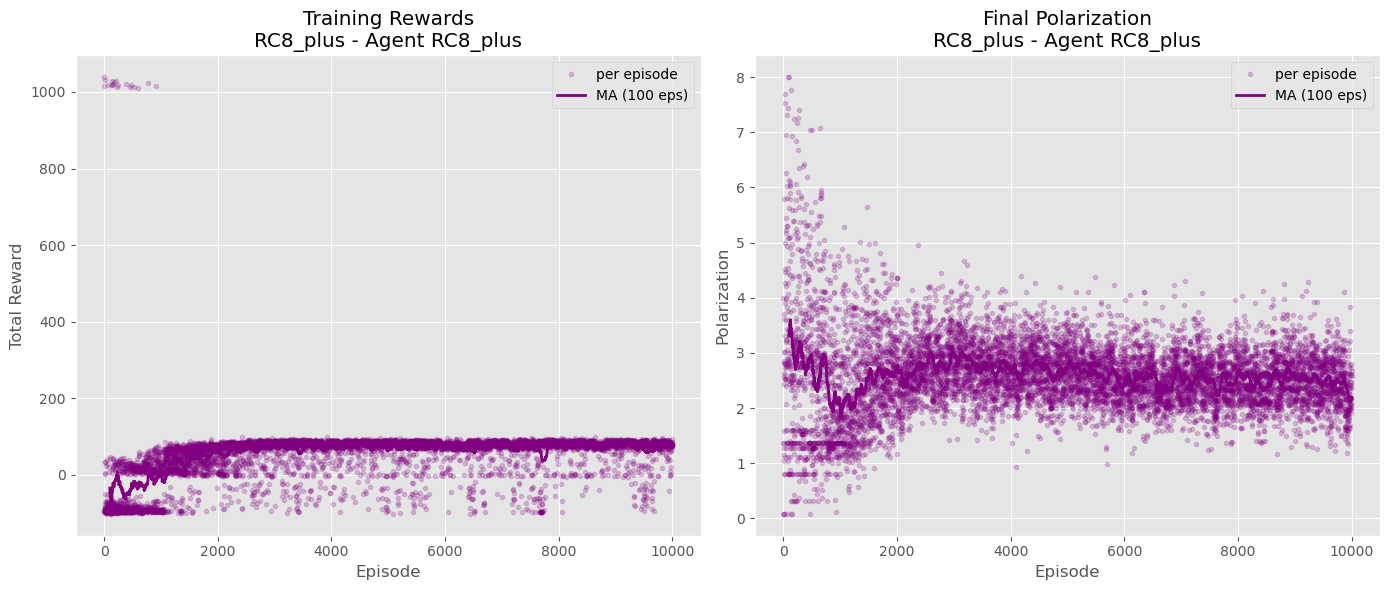


--- Evaluation plots ---


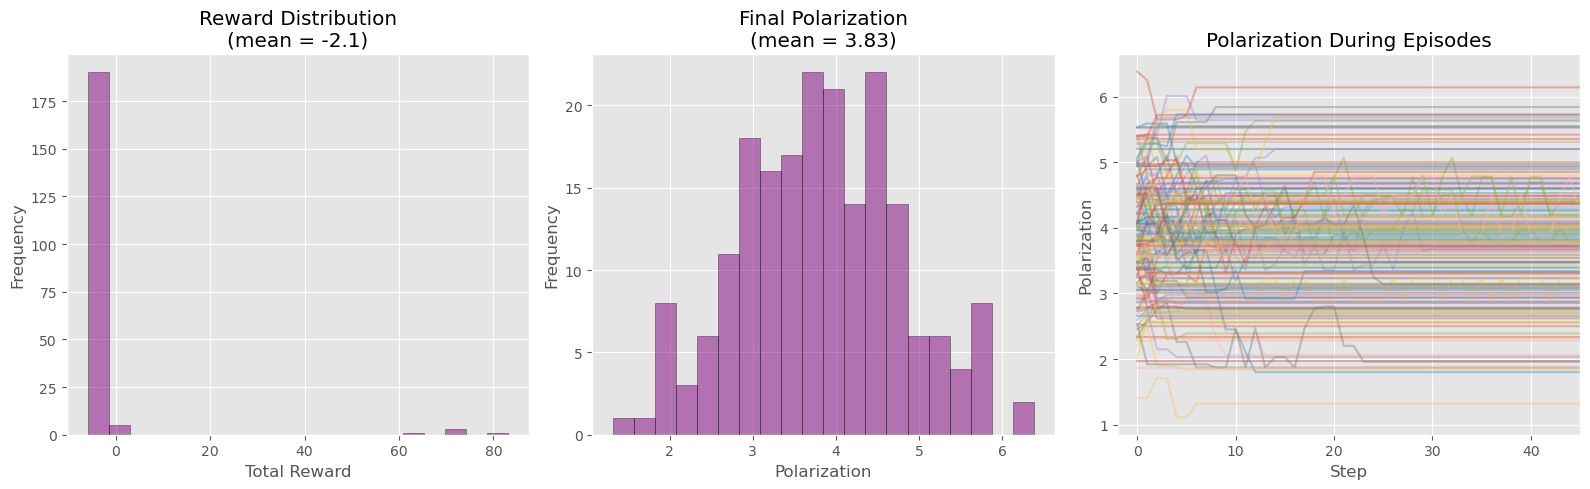

In [41]:
env_RC8_plus = NetworkEnvironment(N=8, graph_type='random', continuous_opinions=True) # echo chamber discrete opinions
env_RC8_plus.reset(regenerate_graph=True)  
state_size = env_RC8_plus.N
initial_action_size = len(env_RC8_plus.actions)

agent_RC8_plus = DQNAgent(state_size, initial_action_size)
train_RC8_plus = train_dqn_agent(env_RC8_plus, agent_RC8_plus, env_name='RC8_plus', agent_name='Agent RC8_plus', episodes=10000)
plot_training_progress(train_RC8_plus, window_size=100)

eval_RC8_plus = evaluate_agent(env_RC8_plus, agent_RC8_plus)
plot_evaluation_results(eval_RC8_plus)